*Antonio Coín Castro*     


# Bayesian RKHS-based Functional Linear Regression

In [57]:
# -- Libraries

import os
import pickle
import sys

import arviz as az
import numpy as np
import pandas as pd
import skfda

from IPython.display import display
from matplotlib import pyplot as plt
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.preprocessing.smoothing.kernel_smoothers import \
    NadarayaWatsonSmoother as NW
from skfda.representation.basis import BSpline, Fourier
from skfda.representation.grid import FDataGrid
from sklearn.model_selection import KFold, train_test_split

import rkbfr.bayesian_model as bayesian_model
import rkbfr.plot_utils as plot_utils
import rkbfr.preprocessing as preprocessing
import rkbfr.simulation as simulation
import rkbfr.utils as utils

from rkbfr._fpls import FPLSBasis
from rkbfr.mle import compute_mle

In [58]:
# -- Configuration

# Extensions
%load_ext autoreload
%autoreload 2

# Plotting configuration
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 4]
plt.style.use('arviz-darkgrid')
NCOLS = 3


def NROWS(x, ncols=NCOLS):
    return np.ceil(x/ncols).astype('int')


# Randomness and reproducibility
SEED = 42
np.random.seed(SEED)
rng = np.random.default_rng(SEED)

# Floating point precision for display
np.set_printoptions(precision=3, suppress=True)
pd.set_option("display.precision", 3)
pd.set_option("styler.format.precision", 3)

# Multiprocessing
N_CORES = 4

# Ignore warnings
np.seterr(over='ignore', divide='ignore')
os.environ["PYTHONWARNINGS"] = 'ignore::UserWarning'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We consider the model

$$
Y = \alpha_0 + \Psi^{-1}_{X}(\alpha) + \varepsilon,
$$

i.e.,

$$
Y_i\mid X_i=x_i \sim \mathcal N\left(\alpha_0 + \sum_{j=1}^p \beta_jx_i(\tau_j), \ \sigma^2\right).
$$

The prior distributions we choose are:

\begin{align*}
  \pi(\alpha_0, \sigma^2)              & \propto 1/\sigma^2,                                                     \\
  \tau                     & \sim \mathscr U([0, 1]^p),                                              \\
  \beta\mid \tau, \sigma^2 & \sim \mathcal N\left(b_0, g\sigma^2\left[\mathcal X_\tau' \mathcal X_\tau + \eta \lambda_{\text{max}}(\mathcal X_\tau' \mathcal X_\tau)I\right]^{-1}\right),
\end{align*}

Note that for computational reasons we will work with $\log \sigma$ instead of $\sigma^2$, and hence the associated prior distribution is

$$
\pi(\alpha_0, \log\sigma) \propto 1.
$$

Writing the parameter vector as $\theta = (\beta, \tau, \alpha_0, \log\sigma)$, the joint posterior probability is:

$$
\pi(\beta, \tau, \alpha_0, \log\sigma\mid Y) \propto \frac{|G_\tau|^{1/2}}{\sigma^{p+n}} \exp\left\{ -\frac{1}{2\sigma^2} \left(\|Y- \alpha_0\boldsymbol{1} - \mathcal X_\tau\beta\|^2 + \frac{1}{g}(\beta - b_0)'G_\tau(\beta - b_0) \right) \right\}.
$$

Hence, the log-posterior probability is:

$$
\log \pi(\beta, \tau, \alpha_0, \log\sigma\mid Y) \propto \frac{1}{2}\log |G_\tau| - (p+n)\log \sigma -\frac{1}{2\sigma^2} \left(\|Y-\alpha_0\boldsymbol{1} - \mathcal X_\tau\beta\|^2 + \frac{1}{g}(\beta - b_0)'G_\tau(\beta - b_0) \right).  
$$



The metrics considered for model evaluation will be:

- RMSE.
- $R^2$.

## Example dataset

We generate a toy dataset with $n=100$ functional regressors $X_i(t) \sim GP(0, K(s, t))$, a response variable given by either a $L^2$ model or a "simple" RKHS function, a value of $\alpha_0=5$ and a variance of $\sigma^2=0.5$. More precisely, we choose one of

$$
Y_i \sim \mathcal N\big(5 -5X_i(0.1) + 10X_i(0.8), \ 0.5\big)
$$

or

$$
Y_i \sim \mathcal N\left(5 + \int_0^1 \beta(t)X_i(t)\, dt, \ 0.5\right),
$$

where $\beta \in L^2[0, 1]$.

We consider a regular grid of $N=100$ points on $[0, 1]$. In addition, we center the $X_i$ so that they have zero mean when fed to the sampling algorithms.

We also generate a test dataset with $n_{\text{test}}=50$ regressors for model evaluation.

In [122]:
# -- Data generation parameters

SYNTHETIC_DATA = True
REGRESSOR_GEN = "GP"  # 'GP' or 'GBM'
MODEL_GEN = "RKHS"  # 'L2' or 'RKHS'
REAL_DATA = "Sugar"

INITIAL_SMOOTHING = None  # None, 'NW' or 'Basis'
N_BASIS = 16
SCALE_PREDICTORS = False
STANDARDIZE_RESPONSE = False

n_train, n_test = 100, 50
N = 100
tau_range = (0, 1)

mean_vector = np.zeros(N)
kernel_fn = simulation.geometric_brownian_kernel
basis = BSpline(n_basis=N_BASIS)
smoothing_params = np.logspace(-4, 4, 50)

In [123]:
# -- Dataset generation

if SYNTHETIC_DATA:
    if REGRESSOR_GEN == "GP":
        x = simulation.gp(grid, mean_vector, kernel_fn)
    grid = np.linspace(tau_range[0] + 1./N, tau_range[1], N)
    alpha0_true = 5.
    sigma2_true = 0.5

    if MODEL_GEN == "L2":
        beta_coef = simulation.cholaquidis_scenario3
        x, y = simulation.generate_gp_l2_dataset(
            grid,
            kernel_fn,
            n_train + n_test,
            beta_coef,
            alpha0_true,
            sigma2_true,
            rng=rng
        )
    elif MODEL_GEN == "RKHS":
        beta_true = [-5., 10.]
        tau_true = [0.1, 0.8]
        x, y = simulation.generate_gp_rkhs_dataset(
            grid,
            kernel_fn,
            n_train + n_test,
            beta_true,
            tau_true,
            alpha0_true,
            sigma2_true,
            rng=rng
        )
    else:
        raise ValueError("Invalid model generation strategy.")

    # Train/test split
    X, X_test, Y, Y_test = train_test_split(
        x, y, train_size=n_train, random_state=SEED)

    # Create FData object
    X_fd = skfda.FDataGrid(X, grid)
    X_test_fd = skfda.FDataGrid(X_test, grid)

else:  # Real data
    if REAL_DATA == "Tecator":
        x, y = skfda.datasets.fetch_tecator(return_X_y=True)
        data = x.data_matrix[..., 0]
        u, idx = np.unique(data, axis=0, return_index=True)
        x = FDataGrid(data[idx], x.grid_points[0]).derivative(order=2)
        y = y[idx, 1]  # Fat level
    elif REAL_DATA == "Moisture":
        data = skfda.datasets.fetch_cran(
            "Moisturespectrum", "fds")["Moisturespectrum"]
        y = skfda.datasets.fetch_cran(
            "Moisturevalues", "fds")["Moisturevalues"]
        x = FDataGrid(data["y"].T[:, ::7], data["x"][::7])
    elif REAL_DATA == "Sugar":
        data = np.load('data/sugar.npz')
        x = FDataGrid(data['x'][:, ::5])
        y = data['y']
    else:
        raise ValueError("REAL_DATA must be 'Tecator' or 'Aemet'.")

    N = len(x.grid_points[0])
    grid = preprocessing.normalize_grid(
        x.grid_points[0], tau_range[0], tau_range[1])
    
    x = FDataGrid(x.data_matrix, grid)

    X_fd, X_test_fd, Y, Y_test = train_test_split(
        x, y, train_size=0.667, random_state=SEED)

    n_train, n_test = len(X_fd.data_matrix), len(X_test_fd.data_matrix)

# Smooth data

if INITIAL_SMOOTHING is not None:
    if INITIAL_SMOOTHING == "NW":
        smoother = NW()
    elif INITIAL_SMOOTHING == "Basis":
        smoother = BasisSmoother(basis)
    else:
        raise ValueError(
            f"Expected 'NW' or 'Basis' but got {INITIAL_SMOOTHING}.")

    X_fd, best_smoother, X_test_fd = preprocessing.smooth_data(
        X_fd,
        smoother,
        smoothing_params,
        X_test_fd
    )

    print(
        "Smoother: {}".format(
            best_smoother.best_estimator_.__class__.__name__))
    print(
        "Smoothing parameter: {:.3f}".format(
            best_smoother.best_params_['smoothing_parameter']))

# Standardize data
X_fd, X_test_fd = preprocessing.standardize_predictors(
    X_fd, X_test_fd, SCALE_PREDICTORS)

if STANDARDIZE_RESPONSE:
    Y, Y_test = preprocessing.standardize_response(Y, Y_test)

# Get data matrices

X = X_fd.data_matrix.reshape(-1, N)
X_test = X_test_fd.data_matrix.reshape(-1, N)

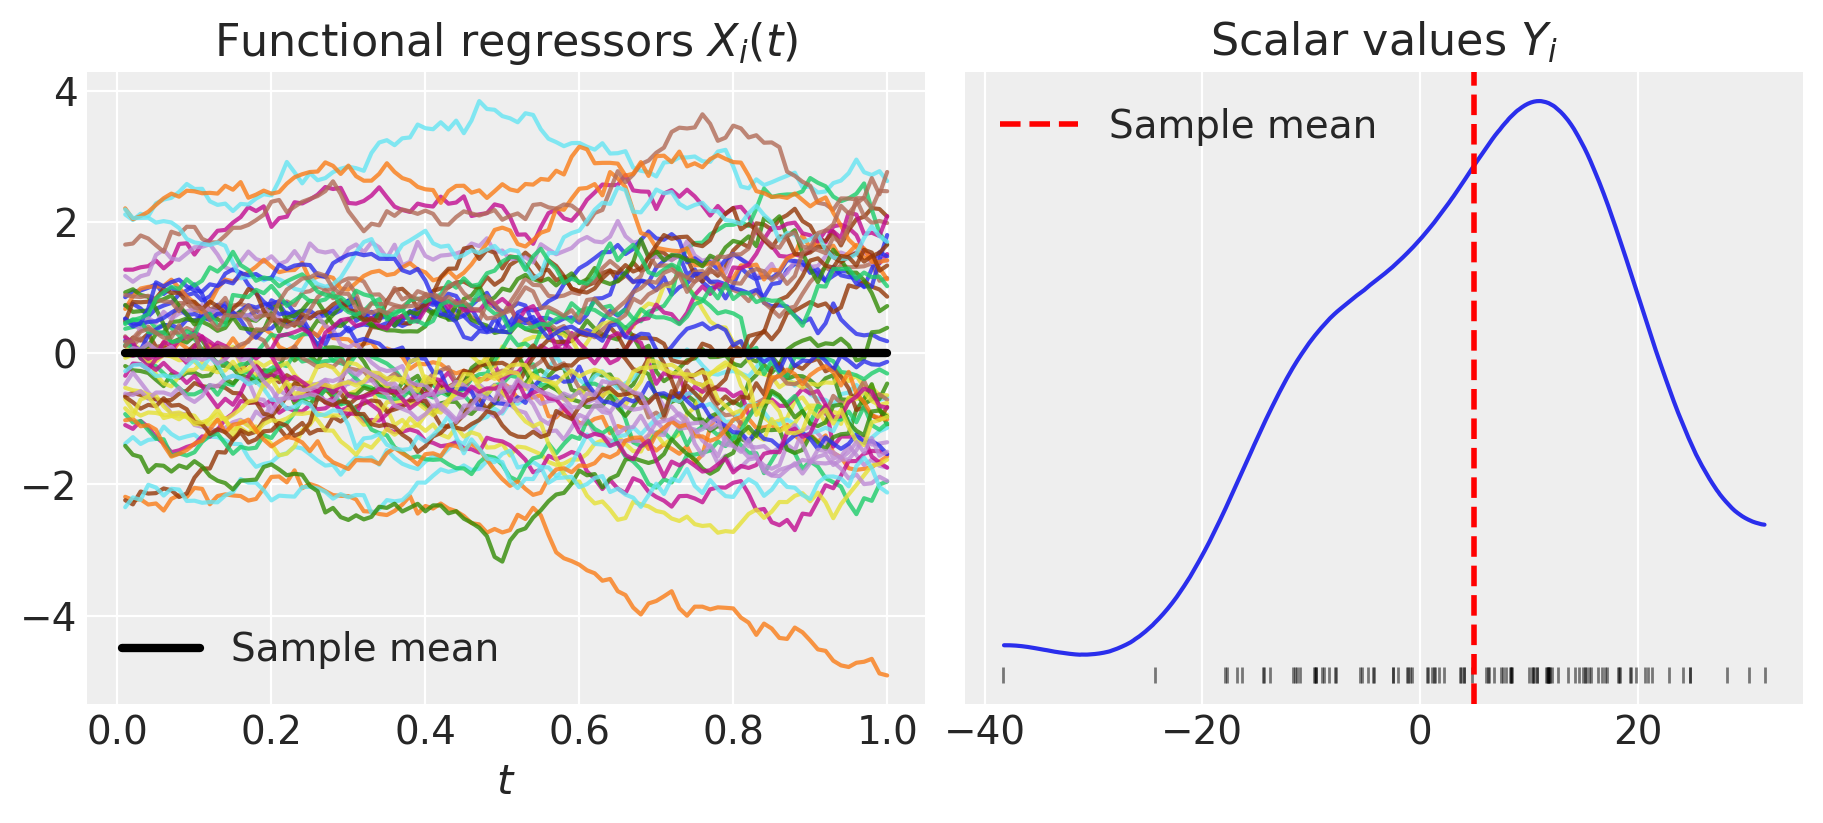

In [124]:
# -- Dataset visualization

plot_utils.plot_dataset_regression(
    X,
    Y,
    n_samples=n_train if not SYNTHETIC_DATA else n_train//2
)

## Common model hyperparameters

In our algorithms, we consider an unconstrained tranformed parameter space $\tilde \Theta=\mathbb{R}^{2\hat p+2}$ via the bijections

- $\tau_j \mapsto \operatorname{logit}(\tau_j)$.
- $\sigma^2 \mapsto \log\sigma$.

In [97]:
# -- Model hyperparameters

p_max = 3
g = 5
eta = 0.000001

mle_method = 'L-BFGS-B'  # 'Nelder-Mead', 'Powell' or 'L-BFGS-B'
mle_strategy = 'global'

prior_p = {
    1: 0.10,
    2: 0.60,
    3: 0.30,
}

beta_range = None
sigma2_ub = np.inf

INCLUDE_P = False
TRANSFORM_TAU = False
TRANSFORM_SIGMA = True
FIT_SK = True
COMPUTE_MLE = True

In [98]:
# -- Names and labels

# Names of parameters
theta_names = ["β", "τ", "α0", "σ2"]
if INCLUDE_P:
    theta_names = ["p"] + theta_names

# Grouped labels
theta_labels_grouped = [r"$\beta$", r"$\tau$", r"$\alpha_0$", r"$\sigma^2$"]
if INCLUDE_P:
    theta_labels_grouped = [r"$p$"] + theta_labels_grouped

# Individual labels
theta_labels = [] if not INCLUDE_P else [theta_labels_grouped[0]]
for i in range(p_max):
    theta_labels.append(fr"$\beta_{i + 1}$")
for i in range(p_max):
    theta_labels.append(fr"$\tau_{i + 1}$")
theta_labels.append(theta_labels_grouped[-2])
theta_labels.append(theta_labels_grouped[-1])

# Labels for Arviz
dim_name = "theta"
theta_labeller = az.labels.MapLabeller(
    var_name_map=dict(zip(theta_names[-2:], theta_labels_grouped[-2:])),
    coord_map={dim_name: dict(
        zip(np.arange(p_max), np.arange(1, p_max + 1)))}
)

In [99]:
# -- Parameter space and miscellaneous

if TRANSFORM_TAU:
    tau_ttr = bayesian_model.Logit()
else:
    tau_ttr = bayesian_model.Identity()

if TRANSFORM_SIGMA:
    sigma2_ttr = bayesian_model.LogSq()
else:
    sigma2_ttr = bayesian_model.Identity()

# Parameter space
theta_space = bayesian_model.ThetaSpace(
    p_max,
    grid,
    include_p=INCLUDE_P,
    names=theta_names,
    labels=theta_labels,
    labeller=theta_labeller,
    tau_range=tau_range,
    beta_range=beta_range,
    tau_ttr=tau_ttr,
    sigma2_ttr=sigma2_ttr,
    sigma2_ub=sigma2_ub
)

# Statistics for posterior predictive checks
point_estimators_bpv = [
    ("min", np.min),
    ("max", np.max),
    ("median", np.median),
    ("mean", np.mean),
    ("std", np.std)
]

# Folds for CV
folds = KFold(shuffle=True, random_state=SEED)

# Column to order results
sort_by = -2

## Sklearn model comparison

In [65]:
# -- Select family of regressors

alphas = np.logspace(-4, 4, 20)
n_selected = [5, 10, 15, 20, 25, 50]
n_components = [2, 3, 4, 5, 7, 10, 15, 20]
n_basis_bsplines = [8, 10, 12, 14, 16]
n_basis_fourier = [3, 5, 7, 9, 11]

basis_bspline = [BSpline(n_basis=p) for p in n_basis_bsplines]
basis_fourier = [Fourier(n_basis=p) for p in n_basis_fourier]

params_regularizer = {"reg__alpha": alphas}
params_select = {"selector__p": n_selected}
params_pls = {"reg__n_components": n_components}
params_dim_red = {"dim_red__n_components": n_components}
params_basis = {"basis__basis": basis_bspline + basis_fourier}

regressors = utils.linear_regression_comparison_suite(
    params_regularizer,
    params_select,
    params_dim_red,
    params_basis,
    params_pls,
    random_state=SEED
)

In [66]:
# -- Fit models and show metrics

if FIT_SK:
    df_metrics_sk, reg_cv = utils.cv_sk(
        regressors,
        X_fd,
        Y,
        X_test_fd,
        Y_test,
        folds,
        kind='linear',
        n_jobs=N_CORES,
        sort_by=sort_by,
        verbose=True
    )
    display(df_metrics_sk.style.hide(axis="index"))

  Fitting lasso...


 /home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.632e+01, tolerance: 2.698e-01


  Fitting ridge...
  Fitting pls1...
  Fitting manual+ridge...


 /home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning:The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).


  Fitting fpca+ridge...
  Fitting pca+ridge...
  Fitting pls+ridge...
  Fitting rmh+ridge...
  Fitting apls...
  Fitting flin...
  Fitting fpls1...


 /home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:
140 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/antcc/MCD/TFM/bayesian-functional-regression/bfr/_fpls.py", line 236, in fi

## Maximum Likelihood Estimator

In [67]:
# -- MLE computation

if COMPUTE_MLE:
    print(f"-- Computing MLE with {N_CORES} independent runs --")

    theta_space_fixed = theta_space.copy_p_fixed()

    mle_theta, bic = compute_mle(
        X,
        Y,
        theta_space_fixed,
        kind='linear',
        method=mle_method,
        strategy=mle_strategy,
        n_jobs=N_CORES,
        rng=rng
    )

    Y_pred_mle = bayesian_model.generate_response_linear(
        X_test, mle_theta, theta_space_fixed, noise=False
    )

    df_metrics_mle = utils.linear_regression_metrics(
        Y_test,
        Y_pred_mle,
        theta_space.p_max,
        "mle"
    )
    print(f"\nBIC [p={p_max}]: {bic:.3f}")
    display(pd.DataFrame(zip(theta_space_fixed.labels, mle_theta),
                         columns=["", "MLE"]).style.hide(axis="index"))
    print("Regression metrics:")
    display(df_metrics_mle.style.hide(axis="index"))

-- Computing MLE with 4 independent runs --

BIC [p=3]: 450.013


Regression metrics:


## The Ensemble Sampler and the *emcee* library

In [68]:
from rkbfr.mcmc_sampler import BFLinearEmcee
import emcee

### Experiments

We set up the initial points of the chains to be in a random neighbourhood around the MLE to increase the speed of convergence.

In [100]:
# -- Sampler parameters

n_walkers = 32
n_iter_warmup = 100
n_iter = 700

compute_pp = False
compute_ll = False
frac_random = 0.2

moves = [
    (emcee.moves.StretchMove(), 0.7),
    (emcee.moves.WalkMove(), 0.3)
]

thin = 1
thin_pp = 5
burn = 200

FAST_RUN = True
COMPUTE_METRICS_FAST_RUN = True

In [101]:
# -- Run sampler

print("-- Running affine-invariant ensemble sampler "
      f"with {N_CORES} cores --")

reg_emcee = BFLinearEmcee(
    theta_space,
    n_walkers,
    n_iter,
    b0='mle',
    g=g,
    eta=eta,
    prior_p=prior_p,
    n_iter_warmup=n_iter_warmup,
    initial_state='mle',
    frac_random=frac_random,
    moves=moves,
    compute_pp=compute_pp,
    compute_ll=compute_ll,
    thin=thin,
    thin_pp=thin_pp,
    burn=burn,
    mle_method=mle_method,
    mle_strategy=mle_strategy,
    n_jobs=N_CORES,
    verbose=2,
    progress_notebook=True,
    random_state=rng,  # change to 'SEED' for the same output each time
)

if FAST_RUN:
    df_metrics_emcee = utils.run_bayesian_model(
        reg_emcee,
        X,
        Y,
        X_test,
        Y_test,
        folds,
        n_jobs=N_CORES,
        kind='linear',
        prefix='emcee',
        compute_metrics=COMPUTE_METRICS_FAST_RUN,
        sort_by=sort_by,
        verbose=True,
        notebook=True,
        random_state=SEED,
    )
    if COMPUTE_METRICS_FAST_RUN:
        if COMPUTE_MLE:
            df_metrics_emcee = pd.concat([df_metrics_emcee, df_metrics_mle])
        if FIT_SK:
            df_metrics_emcee = pd.concat([df_metrics_emcee, df_metrics_sk])

        df_metrics_emcee.sort_values(
            df_metrics_emcee.columns[sort_by],
            inplace=True
        )
        display(df_metrics_emcee.style.hide(axis="index"))
else:
    reg_emcee.fit(X, Y)
    print(f"Mean acceptance: {100*reg_emcee.mean_acceptance():.3f}%")

idata_emcee = reg_emcee.get_idata()

-- Running affine-invariant ensemble sampler with 4 cores --
[BFLinearEmcee] Computing MLE...
[BFLinearEmcee] MCMC warmup iterations...


[BFLinearEmcee] MCMC:   0%|          | 0/700 [00:00<?, ?it/s]

[BFLinearEmcee] Discarding the first 200 samples...
Mean acceptance: 3.786%


mean      sd  hdi_3%  hdi_97%     min       max  median    mode
β[1]        -2.325   3.879 -12.593    0.941 -16.605     0.941  -0.960  -0.961
β[2]         1.617   1.713  -0.574    4.783  -1.869     8.127   1.322   0.034
β[3]         4.437   2.838   0.127    8.315  -0.570    10.948   5.098   0.229
τ[1]         0.429   0.381   0.005    0.938   0.001     1.000   0.172   0.076
τ[2]         0.423   0.390   0.020    0.991   0.001     0.995   0.158   0.024
τ[3]         0.352   0.365   0.000    0.913   0.000     0.998   0.136   0.001
$\alpha_0$  14.309   1.185  12.153   16.262  11.594    19.697  14.203  14.277
$\sigma^2$  29.940  95.739   2.071   78.347   2.071  1086.837  10.964   7.368


Computing metrics...

Generating posterior predictive samples...


### Analysis

We analyze the samples of all chains, discarding a few times the integrated autocorrelation times worth of samples. We could also perform *thinning* and take only every $k$-th value. The effective sample size is computed as suggested [here (p.66)](https://www.hds.utc.fr/~tdenoeux/dokuwiki/_media/en/mcmc_slides.pdf). Missing values are replaced with a value of $0$.

In [51]:
# -- Sampler statistics and trace (with burn-in and thinning)

# Get number of samples
n_samples_emcee = reg_emcee.total_samples()

# Get autocorrelation times
autocorr = reg_emcee.autocorrelation_times()

pd.DataFrame(
    zip(theta_labels, autocorr, n_samples_emcee/autocorr),
    columns=["", "Autocorrelation times", "Effective i.i.d samples"]
).style.hide(axis="index")

The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 4;
tau: [17.77  18.743 18.272 18.433 18.478 17.683 17.012 20.142]


In [52]:
# -- Trace summary

reg_emcee.summary()

mean       sd    hdi_3%   hdi_97%       min       max  \
β[1]       -1581.670  288.021 -2159.022 -1102.795 -2693.773  -639.297   
β[2]        -914.079  284.508 -1524.102  -383.924 -2082.523   277.314   
β[3]        4134.263  579.015  3483.321  5175.672  1315.537  7003.605   
τ[1]           0.304    0.288     0.074     0.944     0.003     0.999   
τ[2]           0.753    0.291     0.133     1.000     0.000     1.000   
τ[3]           0.962    0.119     0.957     0.995     0.233     0.995   
$\alpha_0$     7.895    0.033     7.852     7.937     7.757     8.139   
$\sigma^2$     0.032    0.030     0.015     0.076     0.014     0.332   

              median      mode  
β[1]       -1577.683 -1495.997  
β[2]        -882.465  -812.728  
β[3]        4132.230  4087.359  
τ[1]           0.167     0.162  
τ[2]           0.870     0.870  
τ[3]           0.988     0.994  
$\alpha_0$     7.894     7.896  
$\sigma^2$     0.025     0.025

Combined density and trace plot:


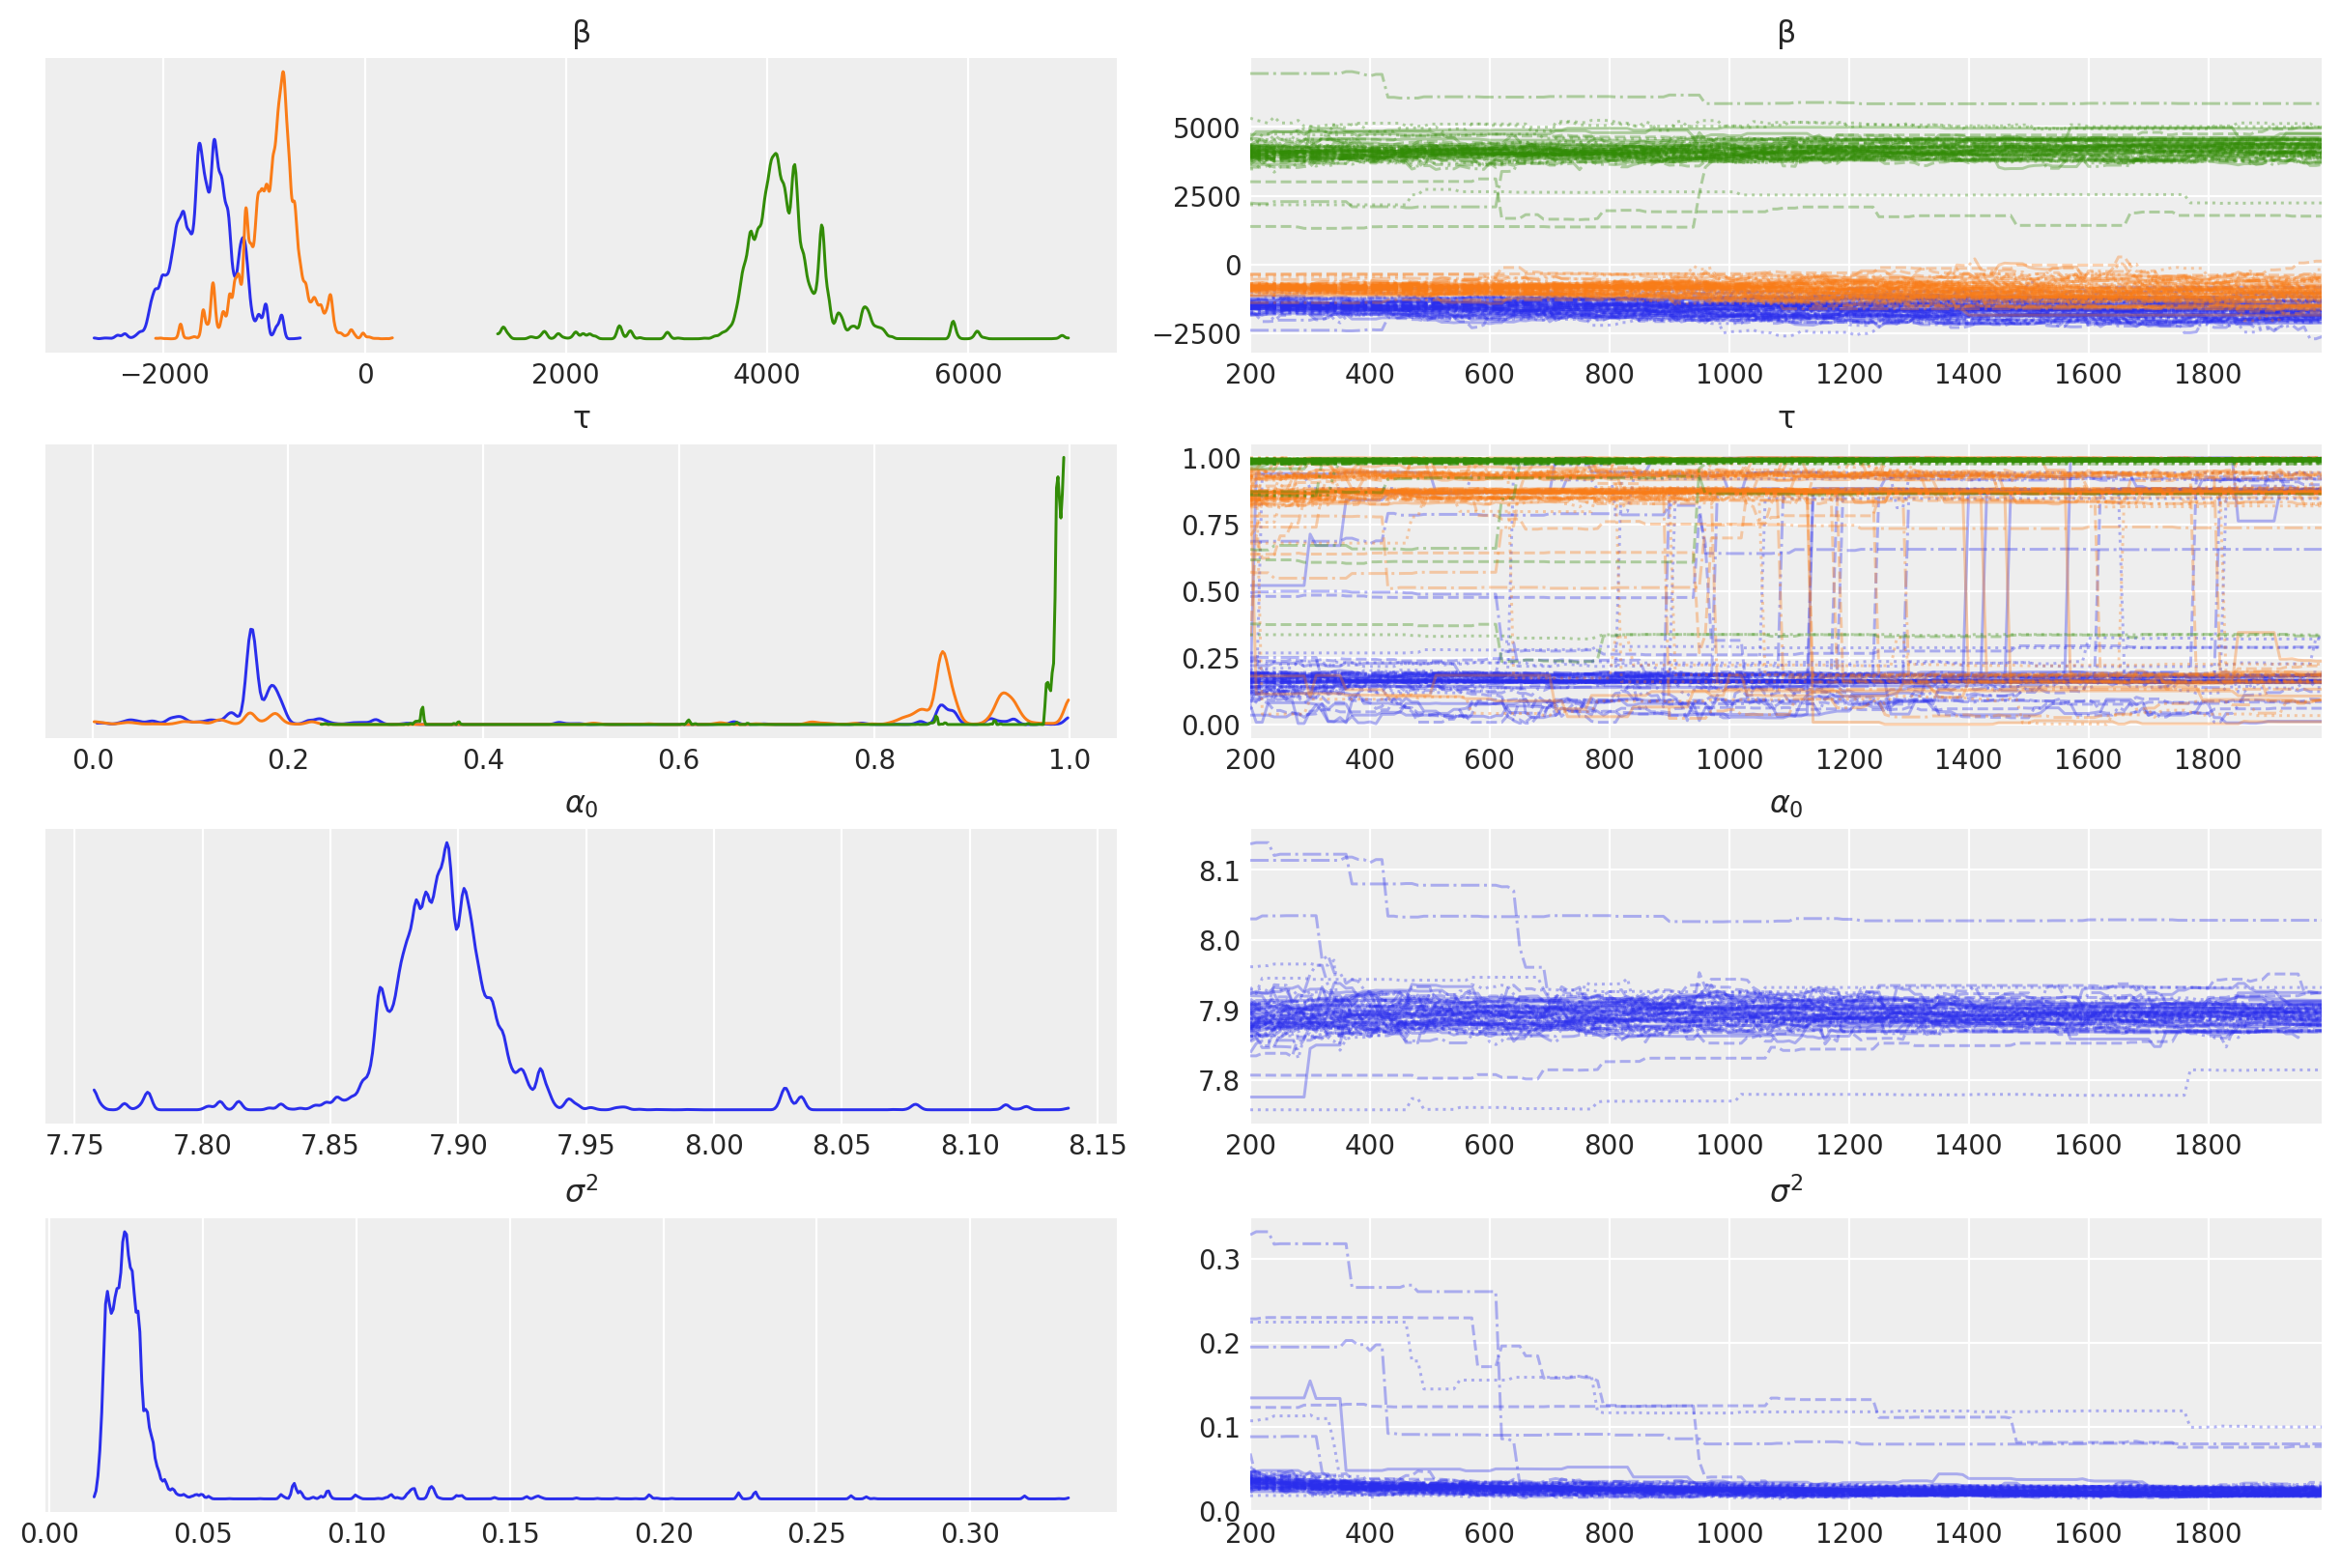

In [53]:
# -- Trace plot

az.plot_trace(
    idata_emcee,
    labeller=theta_labeller,
    combined=True,
    var_names=theta_names
)

print("Combined density and trace plot:")

Marginal posterior distributions:


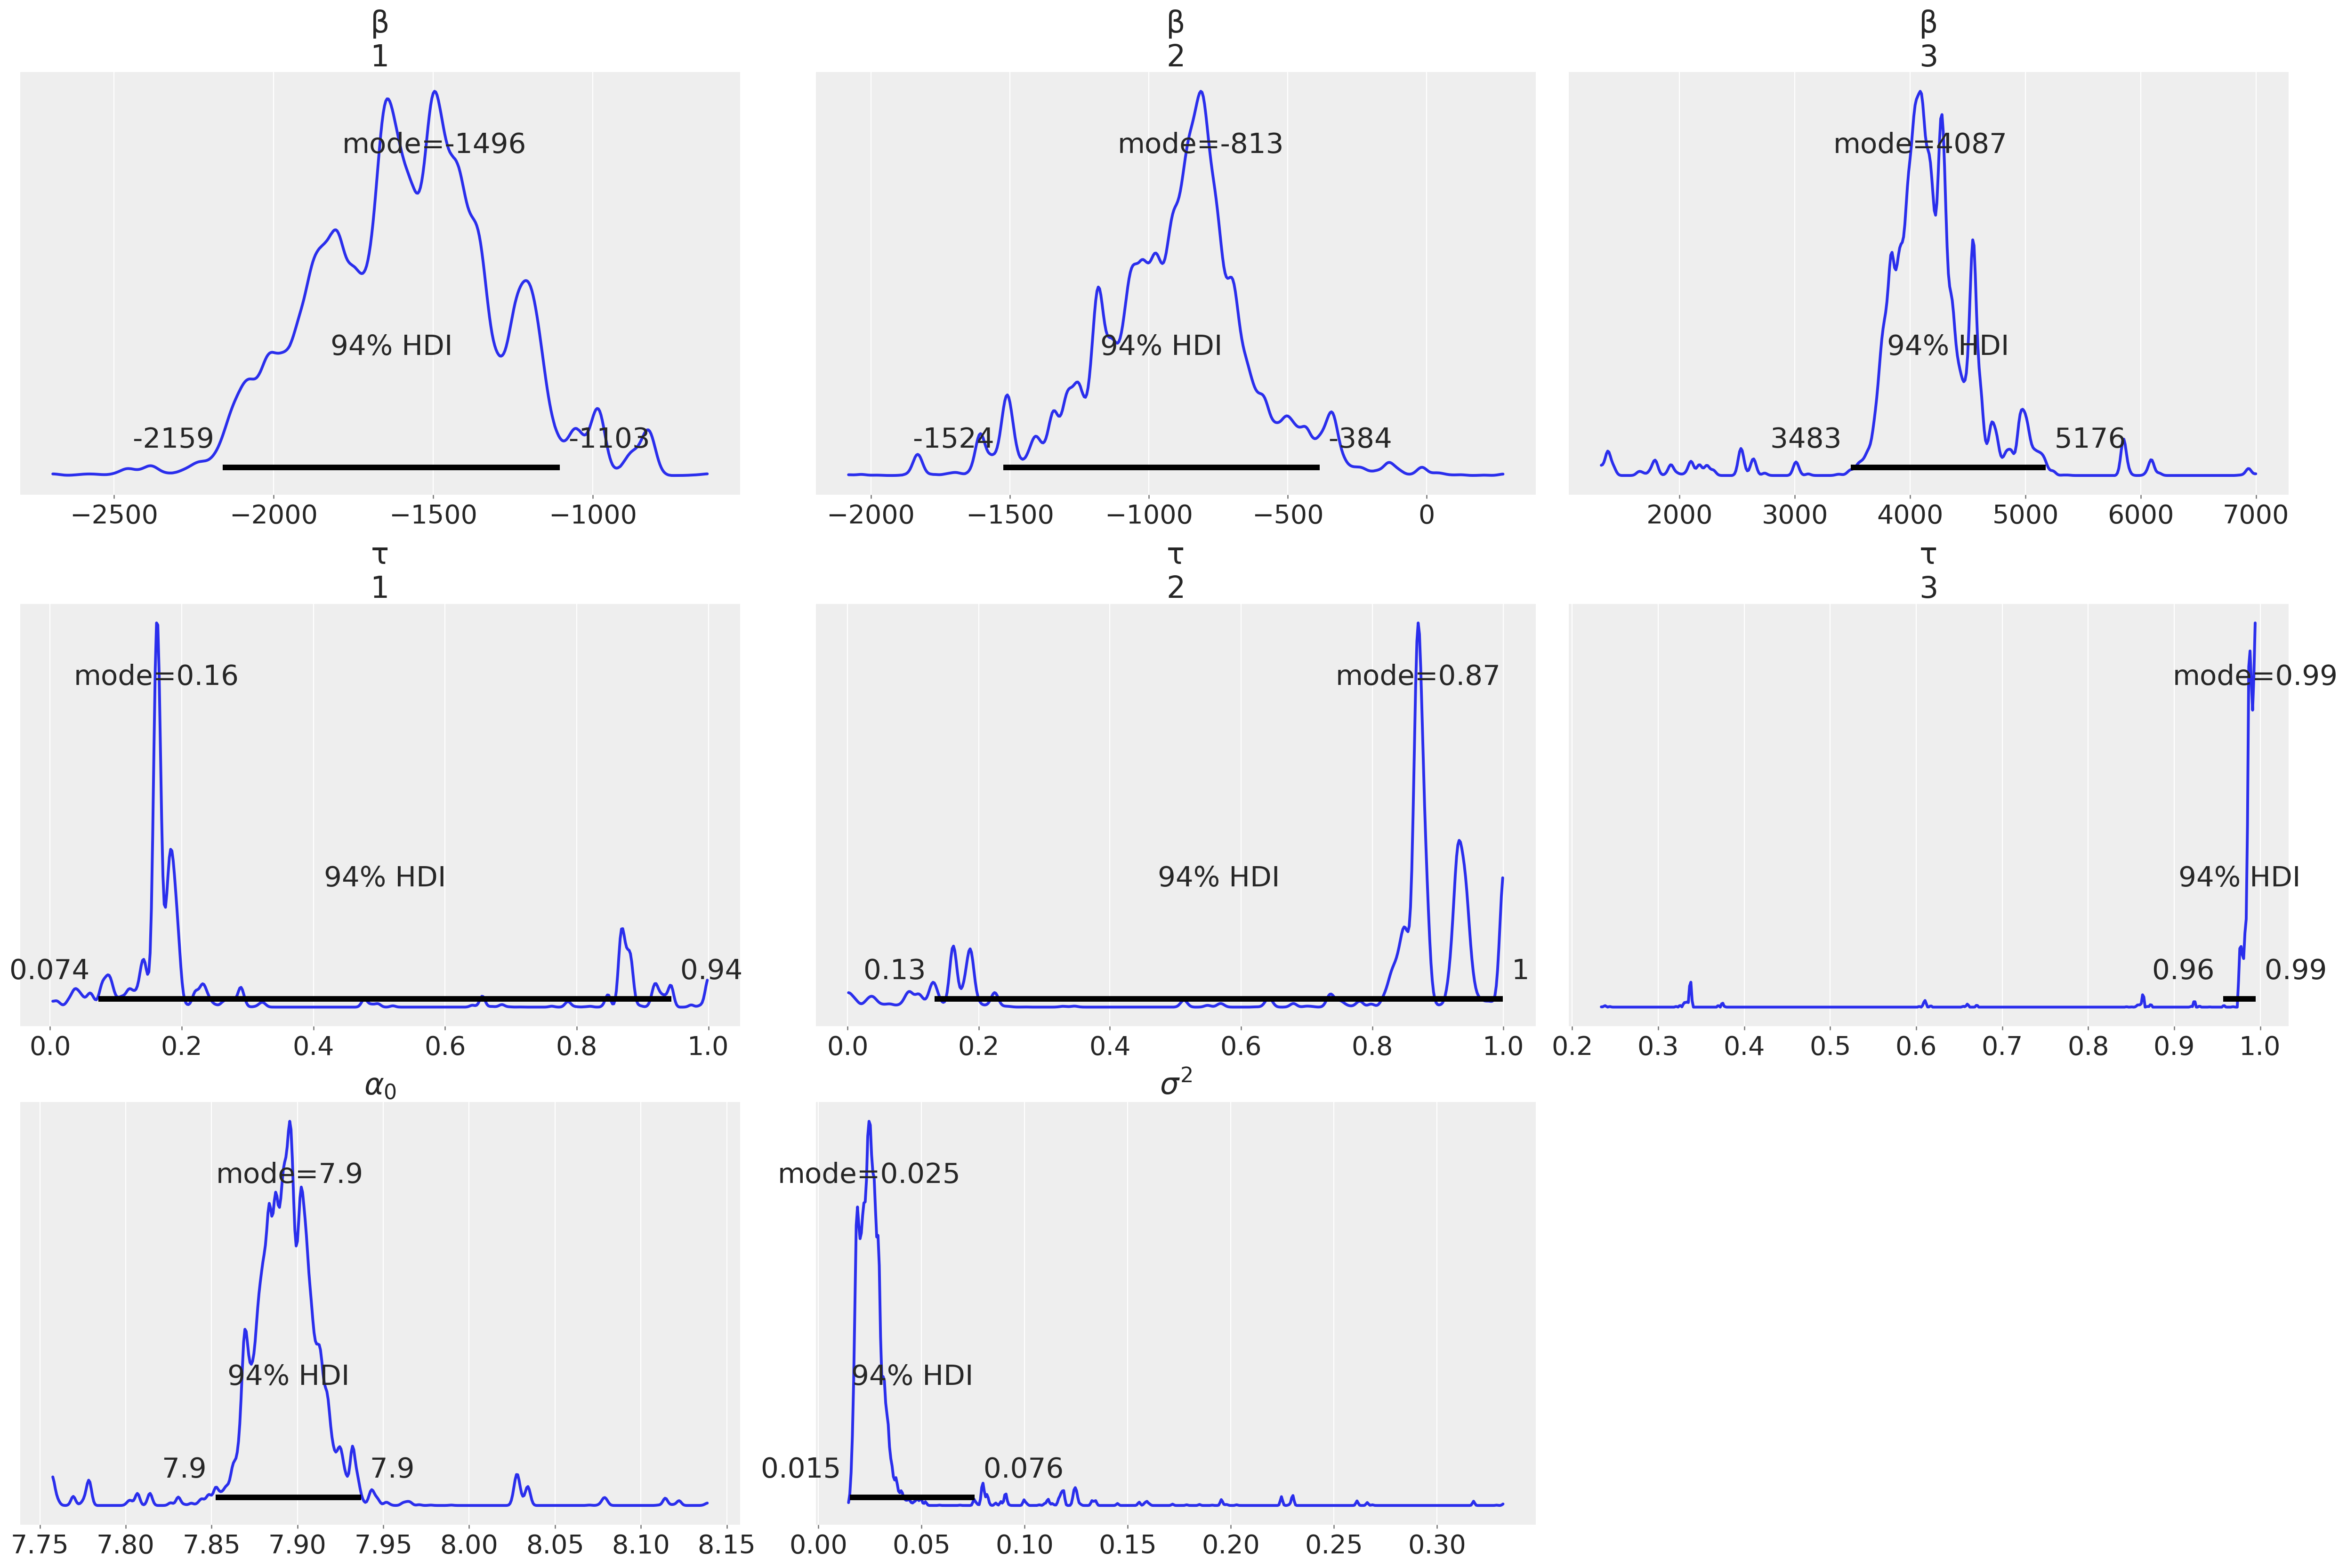

In [54]:
# -- Marginal posterior plot

plot_utils.plot_posterior(
    idata_emcee,
    theta_space,
    gridsize=(NROWS(theta_space.n_dim), NCOLS),
    textsize=20,
)

print("Marginal posterior distributions:")

Forest plot of 94% HDI for β and τ:


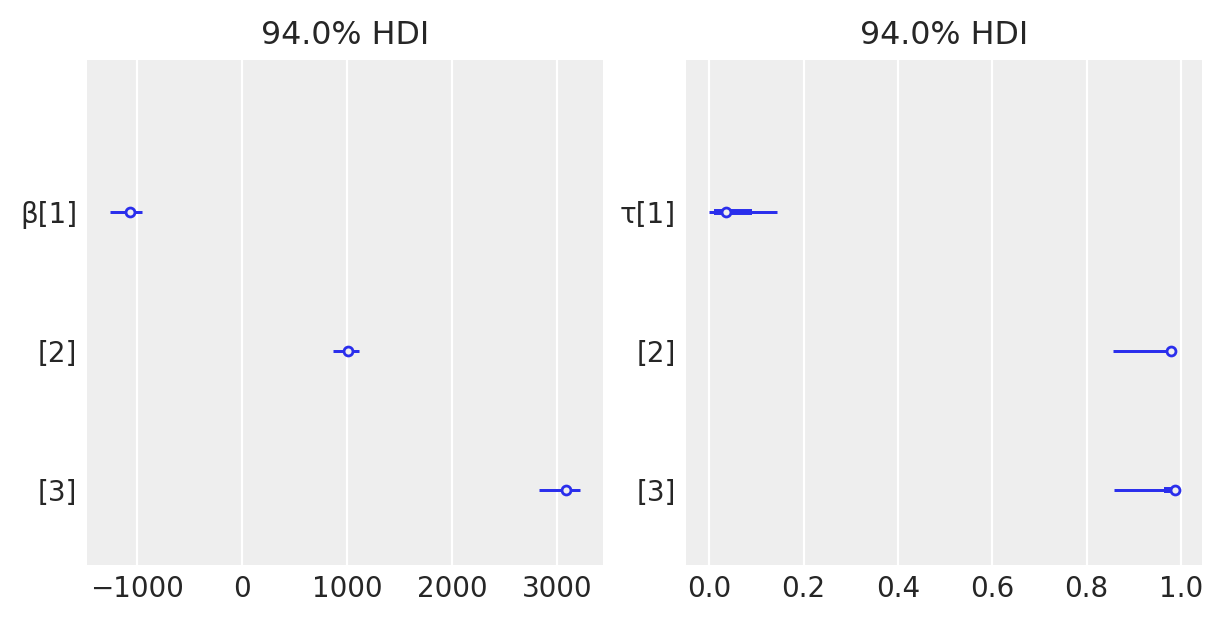

In [34]:
# -- Forest plot

plot_utils.plot_forest(
    idata_emcee, 
    theta_space, 
    textsize=10, 
    var_names=[theta_names[theta_space.beta_idx_grouped], 
               theta_names[theta_space.tau_idx_grouped]]
)

print("Forest plot of 94% HDI for β and τ:")

We can perform a couple of visual posterior predictive checks. In particular:
    
- A plot of the distribution of $Y$ and the distribution of $\{Y^*_m\}_m$ (one for every sample $\theta_m$ of the chain), generated using the original traning data $X$.
- A plot of the distribution of $T(Y^*)$, where $T(x)=\bar x$. 

We also show the Bayesian p-value for several statistics, which is defined as $P(T(y^*)\leq T(y)\mid y)$, and is computed by simply measuring the proportion of generated samples $\{T(Y^*_m)\}_m$ that fall below the real value of the statistic. It is expected to be around $0.5$ when the model accurately represents the data.

Generating posterior predictive samples...
bpv [T=min]: 0.931
bpv [T=max]: 0.007
bpv [T=median]: 0.629
bpv [T=mean]: 0.334
bpv [T=std]: 0.312


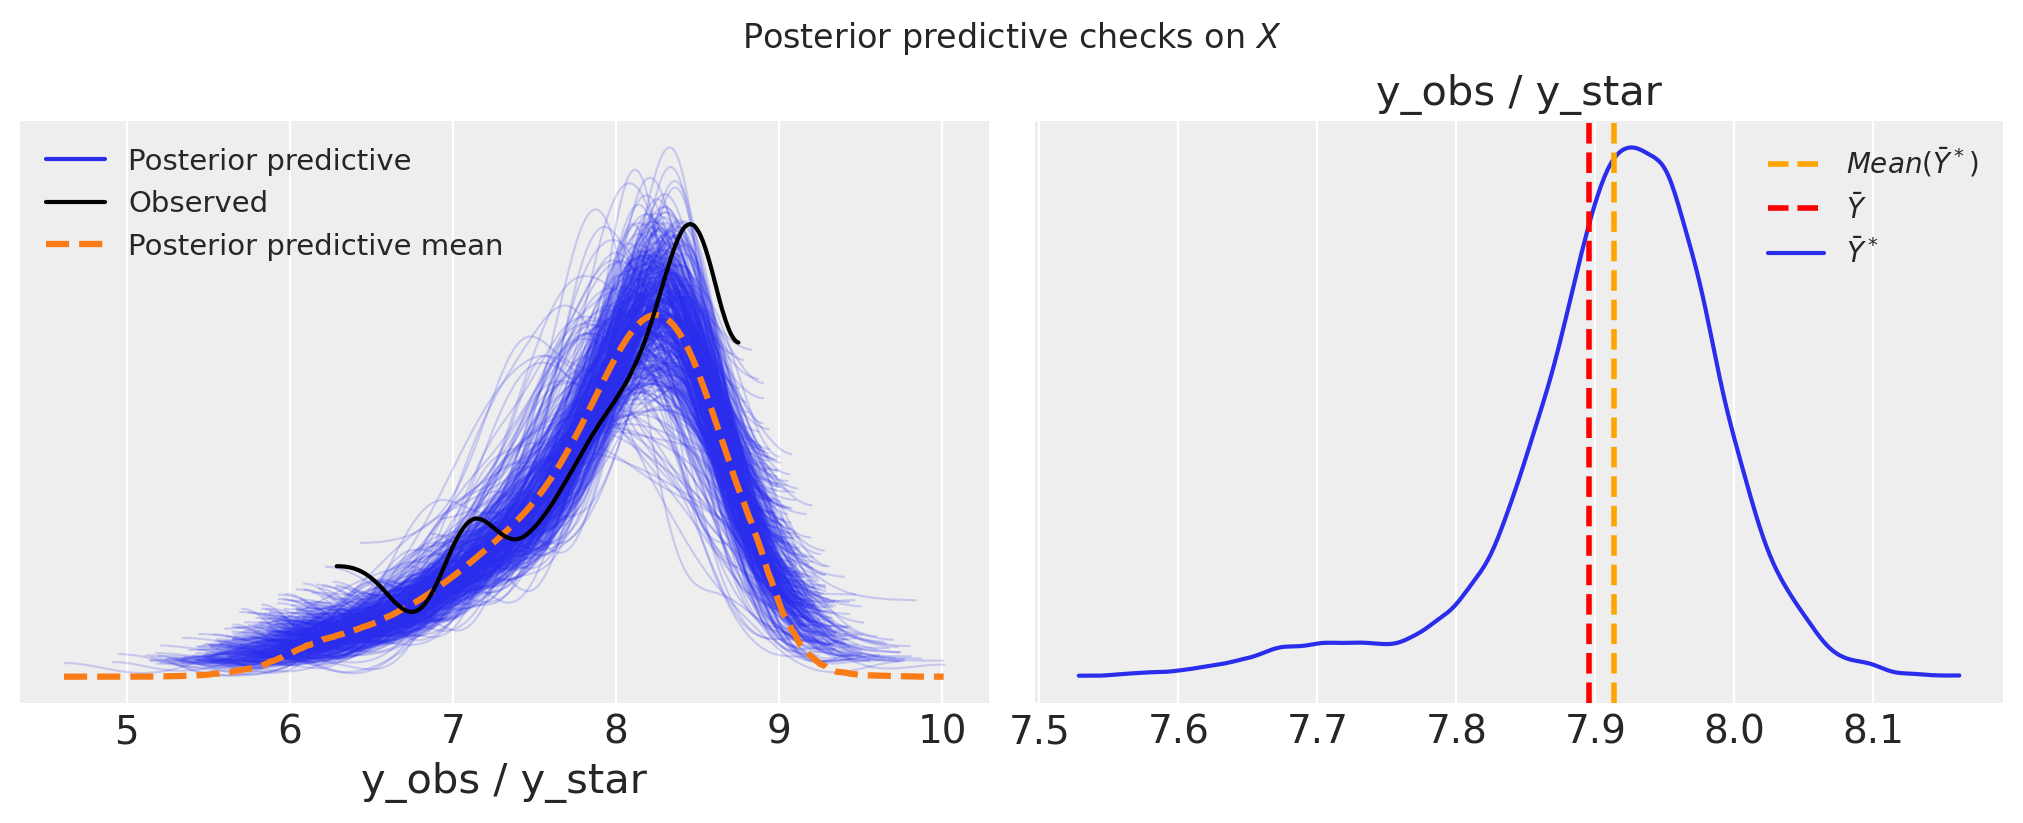

In [47]:
# -- Generate and plot posterior predictive checks from X

if "posterior_predictive" not in idata_emcee:
    pp = bayesian_model.generate_pp(
        idata_emcee, X, theta_space,
        rng=rng, kind='linear', verbose=True)
    utils.pp_to_idata([pp], idata_emcee, ['y_star'], merge=True)
else:
    pp = idata_emcee.posterior_predictive['y_star'].to_numpy()

# Plot posterior predictive checks
plot_utils.plot_checks_linear(idata_emcee, test=False)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = bayesian_model.bpv(pp, Y, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

Combined autocorrelation times:


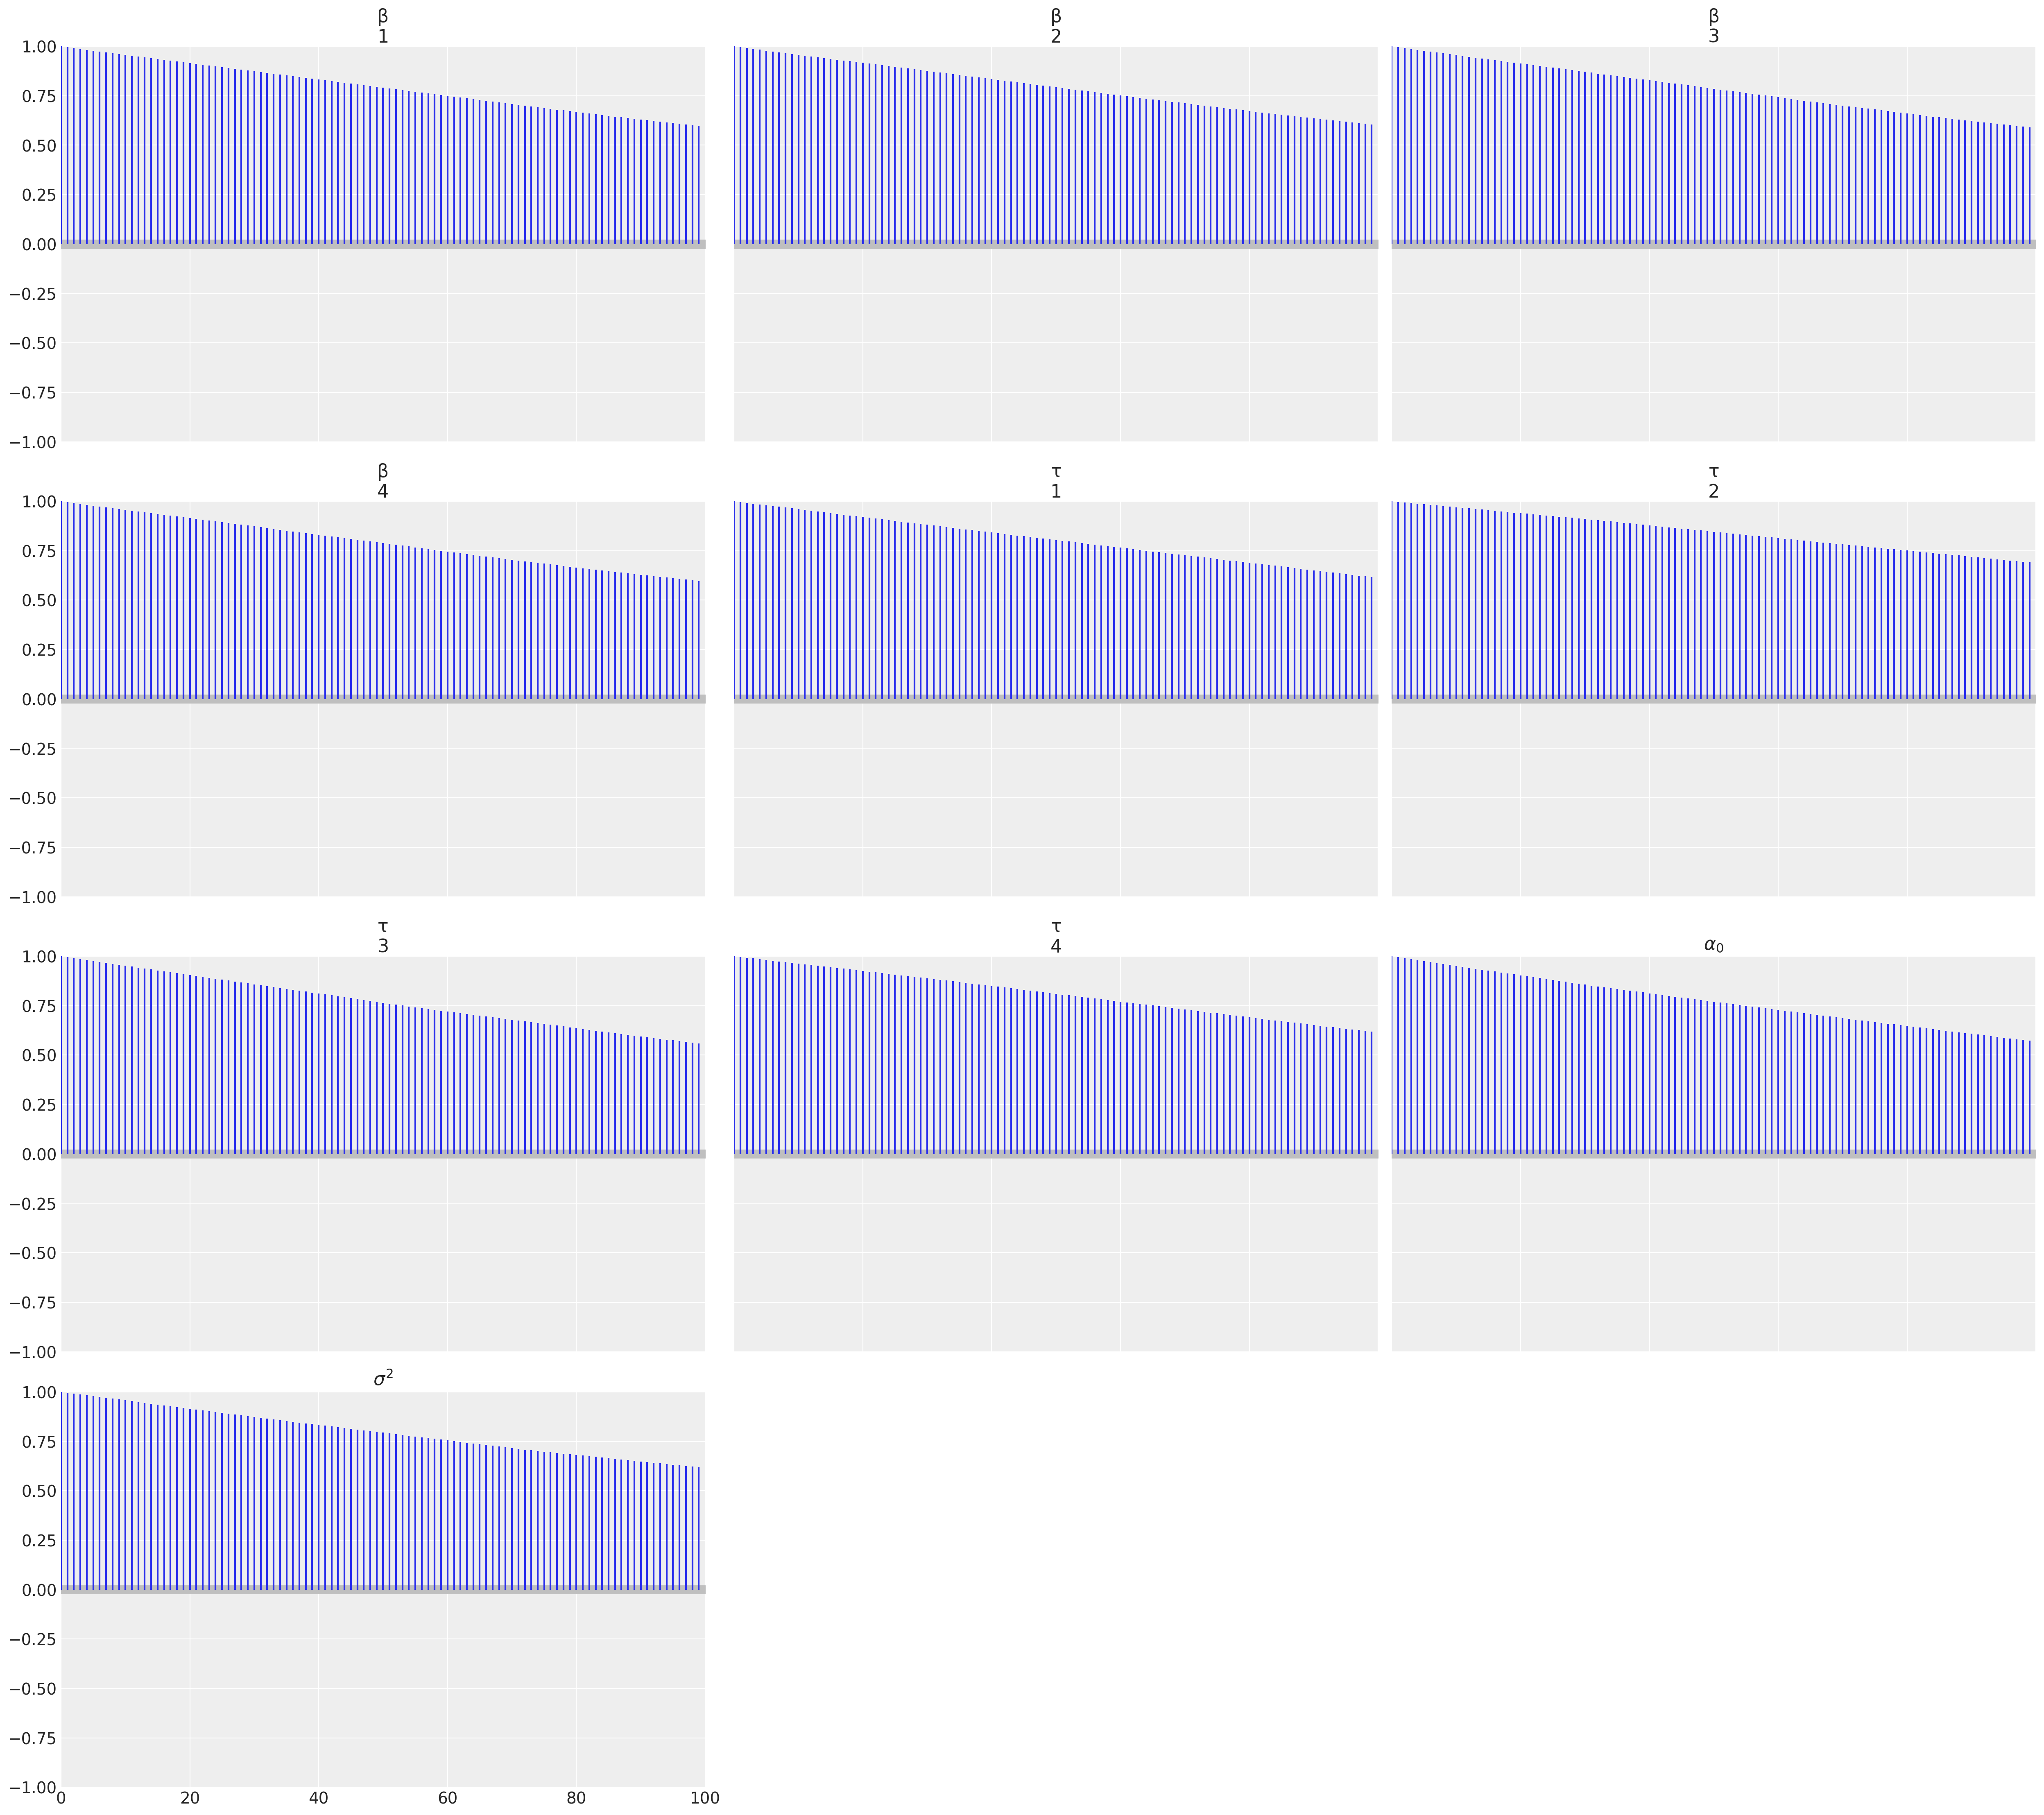

In [24]:
# -- Autocorrelation

plot_utils.plot_autocorr(
    idata_emcee,
    theta_space,
    gridsize=(NROWS(theta_space.n_dim), NCOLS)
)

print("Combined autocorrelation times:")

### Out-of-sample predictions

Generating posterior predictive samples...
bpv [T=min]: 0.505
bpv [T=max]: 0.087
bpv [T=median]: 0.912
bpv [T=mean]: 0.177
bpv [T=std]: 0.999


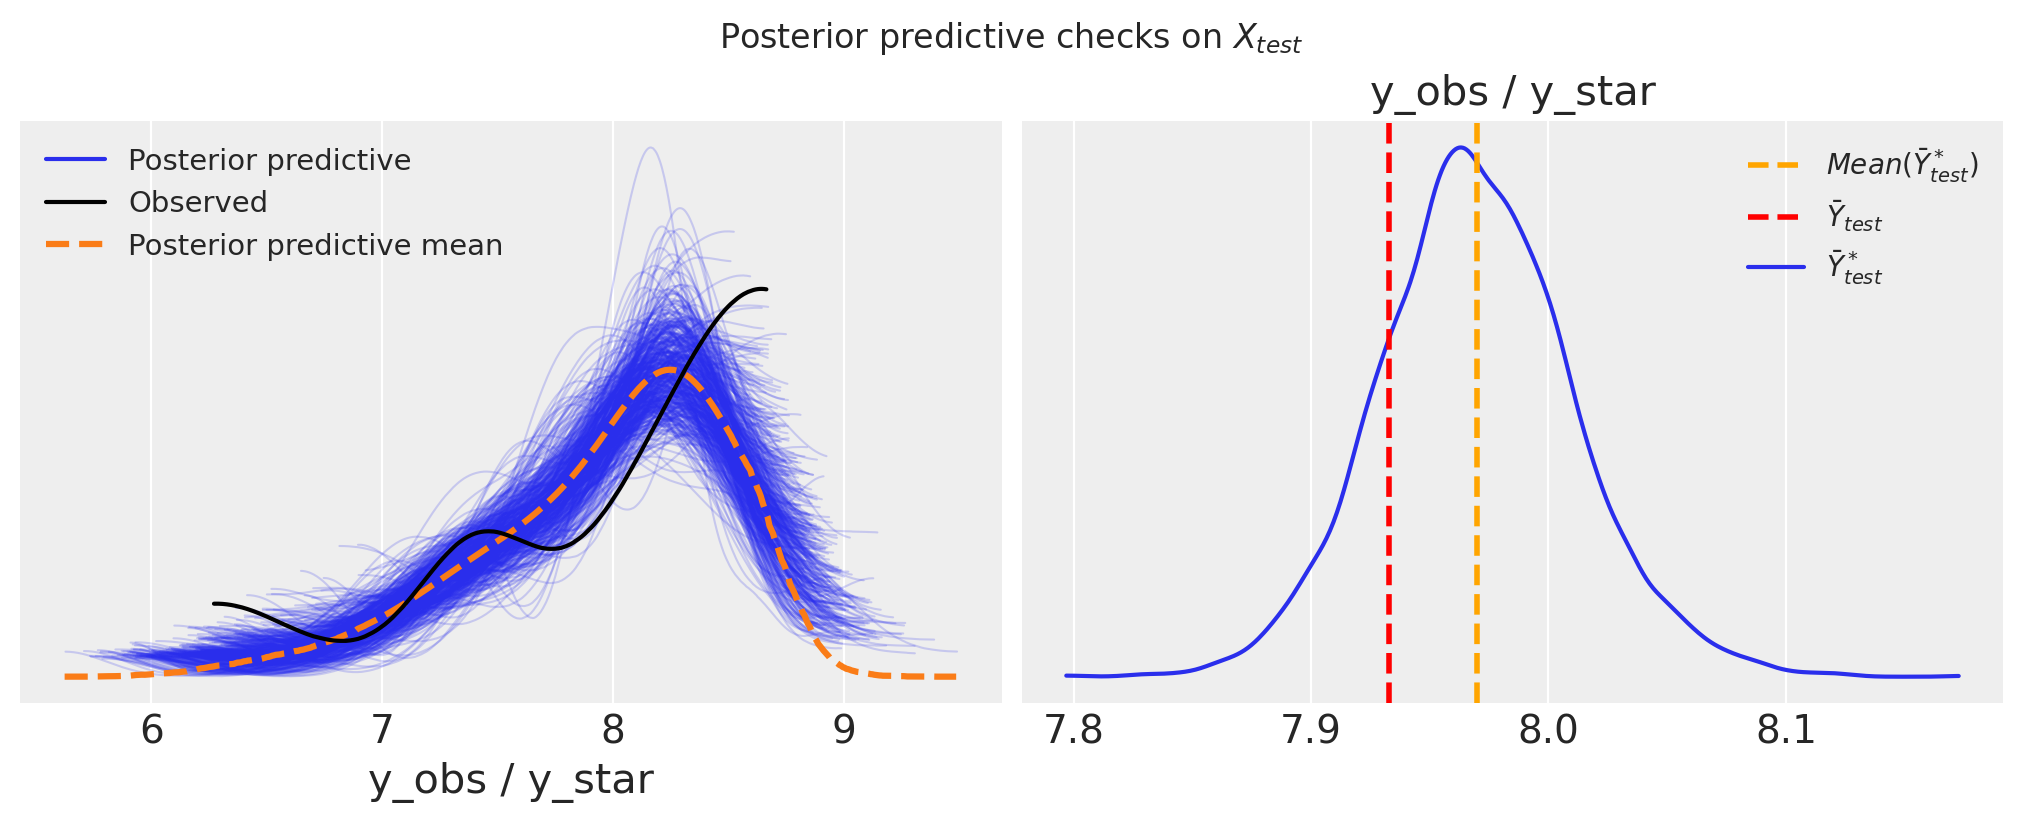

In [36]:
# -- Generate and plot posterior predictive checks from X_test

# Posterior predictive checks
pp_test = bayesian_model.generate_pp(
    idata_emcee,
    X_test,
    theta_space,
    rng=rng,
    kind='linear',
    verbose=True,
)
idata_pp_test = utils.pp_to_idata(
    [pp_test], idata_emcee, ['y_star'], y_obs=Y_test)

# Plot posterior predictive checks
plot_utils.plot_checks_linear(idata_pp_test, test=True)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = bayesian_model.bpv(pp_test, Y_test, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

In [37]:
# -- Compute metrics using several point estimates

# Posterior mean estimate
Y_pred_pp = pp_test[:, ::thin_pp, :].mean(axis=(0, 1))
df_metrics_emcee = utils.linear_regression_metrics(
    Y_test,
    Y_pred_pp,
    reg_emcee.n_components("posterior_mean"),
    "emcee_posterior_mean"
)

# Point estimates
for pe in reg_emcee.default_point_estimates:
    Y_pred_pe = reg_emcee.predict(X_test, strategy=pe)
    df_metrics_emcee = utils.linear_regression_metrics(
        Y_test,
        Y_pred_pe,
        reg_emcee.n_components(pe),
        "emcee_" + pe,
        df=df_metrics_emcee,
    )

df_metrics_emcee.style.hide(axis="index")

In [38]:
# -- Test variable selection procedure

df_metrics_emcee_var_sel = None

for pe in reg_emcee.default_point_estimates:
    X_red = reg_emcee.transform(X, pe=pe)
    X_test_red = reg_emcee.transform(X_test, pe=pe)

    df_metrics_emcee_var_sel = utils.multiple_linear_regression_cv(
        X_red,
        Y,
        X_test_red,
        Y_test,
        folds,
        n_jobs=N_CORES,
        prefix="emcee",
        pe=pe,
        df=df_metrics_emcee_var_sel,
        random_state=SEED
    )

df_metrics_emcee_var_sel.style.hide(axis="index")

### Save & Load

This is only for testing purposes; in a production environment one should use the [Backends](https://emcee.readthedocs.io/en/stable/user/backends/) feature of *emcee*.

In [44]:
# -- Save

with open("emcee-linear.idata", 'wb') as file:
    pickle.dump(idata_emcee, file)

In [45]:
# -- Load

with open("emcee-linear.idata", 'rb') as file:
    idata_emcee = pickle.load(file)
    trace = idata_emcee.posterior.to_array().to_numpy().T
    trace_flat = trace.reshape(-1, trace.shape[-1])  # All chains combined

## The PyMC library

**TODO (v4)**

- Change imports pymc3 -> pymc; theano.tensor -> aesara.tensor
- Try beta = MvNormal
- Try symbolic shape (e.g. tau.shape == p)
- Measure execution times of new pm.sample_posterior_predictive (X should be MutableData (and changed for X_test) for ppc in test set).
- Si beta acaba siendo DensityDist, medir tiempos con y sin parámetros en beta_logp
- Definir adecuadamente los valores iniciales (initval) en p, para que haya al menos uno en cada cadena.
- Añadir random a beta para poder samplear de ella.
- Cambiar start=.. por initvals=... en pm.sample()
- Probar Sequential Monte Carlo
- Probar jax_sampling

In [30]:
from rkbfr.mcmc_sampler import BFLinearPymc
import pymc as pm

### Experiments

In [28]:
# -- Sampler parameters

n_chains = N_CORES
USE_NUTS = False

if USE_NUTS:
    n_samples = 500
    n_tune = 500
    step_fn = pm.NUTS
    step_kwargs = {"target_accept": 0.8}
else:
    n_samples = 5000
    n_tune = 5000
    step_fn = pm.Metropolis
    step_kwargs = {}

burn = 0
thin = 1
thin_pp = 5

FAST_RUN = True
COMPUTE_METRICS_FAST_RUN = True

In [29]:
# -- Run sampler

print(f"-- Running pymc sampler with {N_CORES} cores --")

reg_pymc = BFLinearPymc(
    theta_space,
    n_chains,
    n_samples,
    b0='mle',
    g=g,
    eta=eta,
    prior_p=prior_p,
    step_fn=step_fn,
    step_kwargs=step_kwargs,
    n_iter_warmup=n_tune,
    thin=thin,
    thin_pp=thin_pp,
    burn=burn,
    mle_method=mle_method,
    mle_strategy=mle_strategy,
    n_jobs=N_CORES,
    verbose=2,
    random_state=SEED
)

if FAST_RUN:
    df_metrics_pymc = utils.run_bayesian_model(
        reg_pymc,
        X,
        Y,
        X_test,
        Y_test,
        folds,
        n_jobs=N_CORES,
        kind='linear',
        prefix='pymc',
        compute_metrics=COMPUTE_METRICS_FAST_RUN,
        verbose=True,
        notebook=True,
        sort_by=sort_by,
        random_state=SEED,
    )
    if COMPUTE_METRICS_FAST_RUN:
        if COMPUTE_MLE:
            df_metrics_pymc = pd.concat([df_metrics_pymc, df_metrics_mle])
        if FIT_SK:
            df_metrics_pymc = pd.concat([df_metrics_pymc, df_metrics_sk])

        df_metrics_pymc.sort_values(
            df_metrics_pymc.columns[sort_by],
            inplace=True
        )
        display(df_metrics_pymc.style.hide(axis="index"))
else:
    reg_pymc.fit(X, Y)
    print(f"Mean acceptance: {100*reg_pymc.mean_acceptance():.3f}%")

idata_pymc = reg_pymc.get_idata()

-- Running pymc sampler with 4 cores --
[BFLinearPymc] Computing MLE...


 /home/antcc/MCD/TFM/bayesian-functional-regression/.venv-py39/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning:invalid value encountered in subtract
 /home/antcc/MCD/TFM/bayesian-functional-regression/.venv-py39/lib/python3.9/site-packages/pymc/data.py:667: FutureWarning:The `mutable` kwarg was not specified. Currently it defaults to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default will change to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Set `pm.Data(..., mutable=False/True)`, or use `pm.ConstantData`/`pm.MutableData`.


AttributeError: 'int' object has no attribute 'name'

### Analysis

Since the tuning iterations already serve as burn-in, we keep the whole trace. In addition, we could consider thinning the samples.

In [30]:
# -- Trace summary

reg_pymc.summary(stats='all')

AttributeError: 'BFLinearPymc' object has no attribute 'idata_'

Combined density and trace plot:


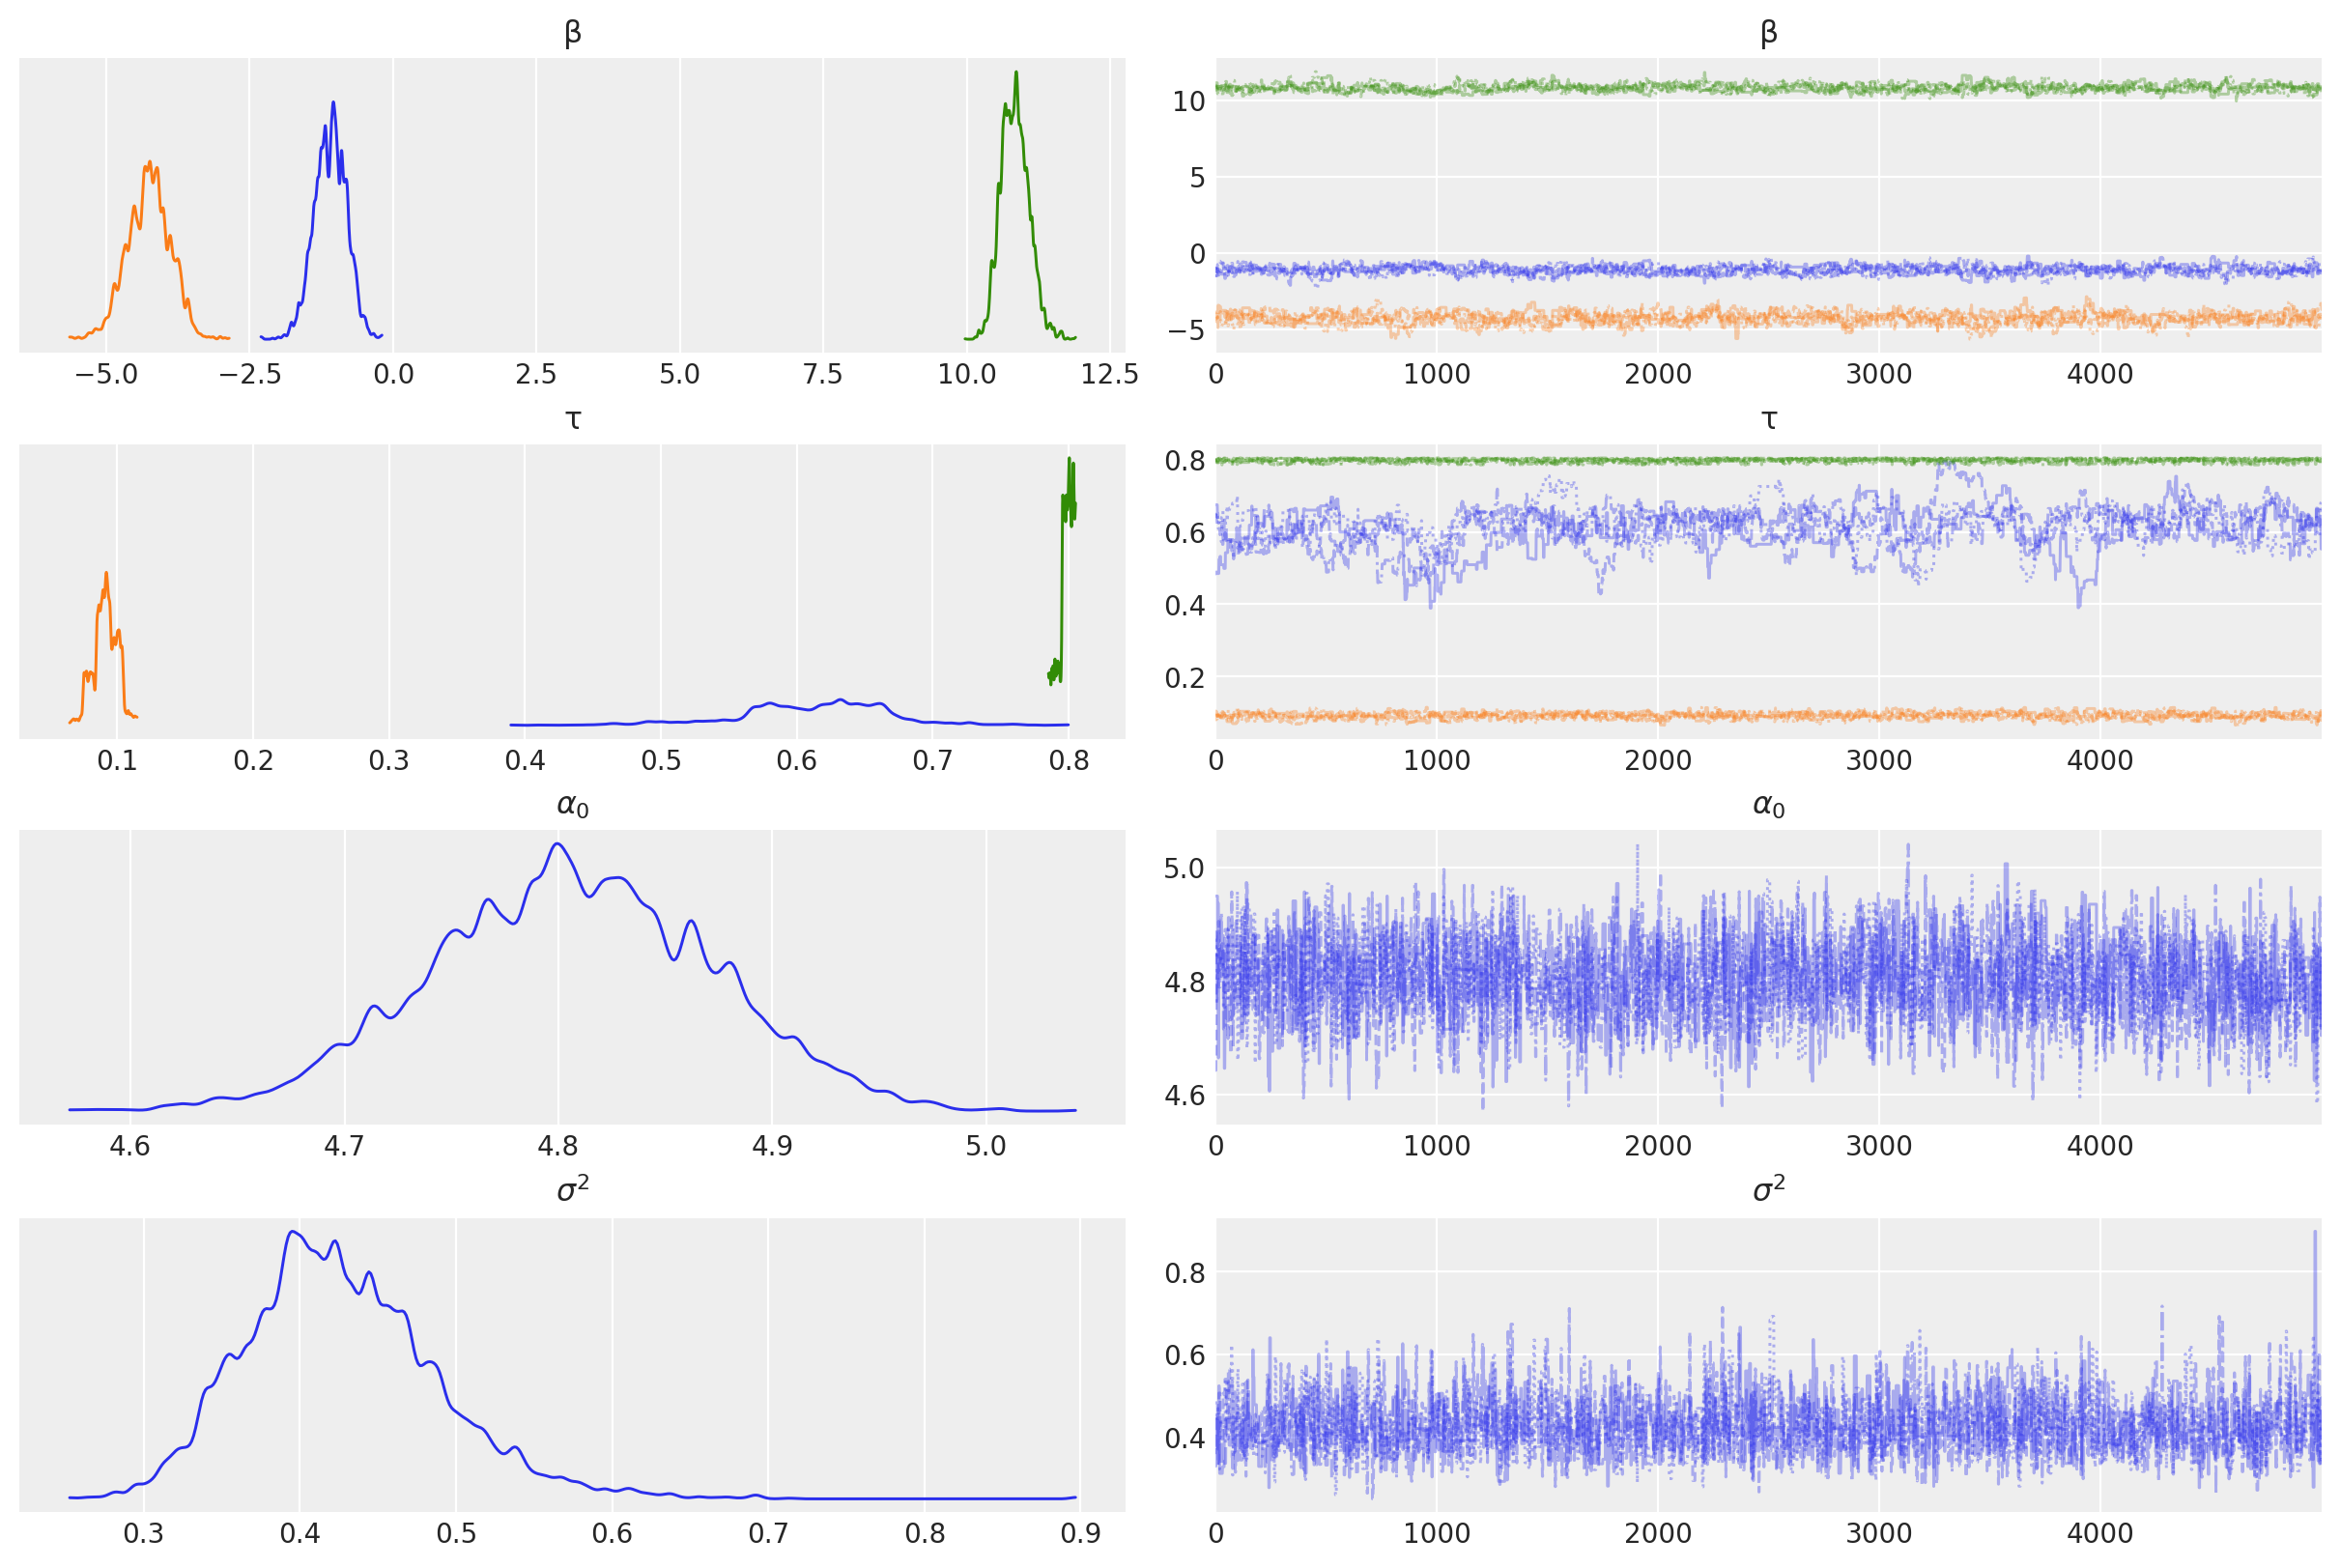

In [28]:
# -- Trace plot

az.plot_trace(
    idata_pymc,
    labeller=theta_labeller,
    combined=True,
    var_names=theta_names
)
print("Combined density and trace plot:")

Marginal posterior distributions:


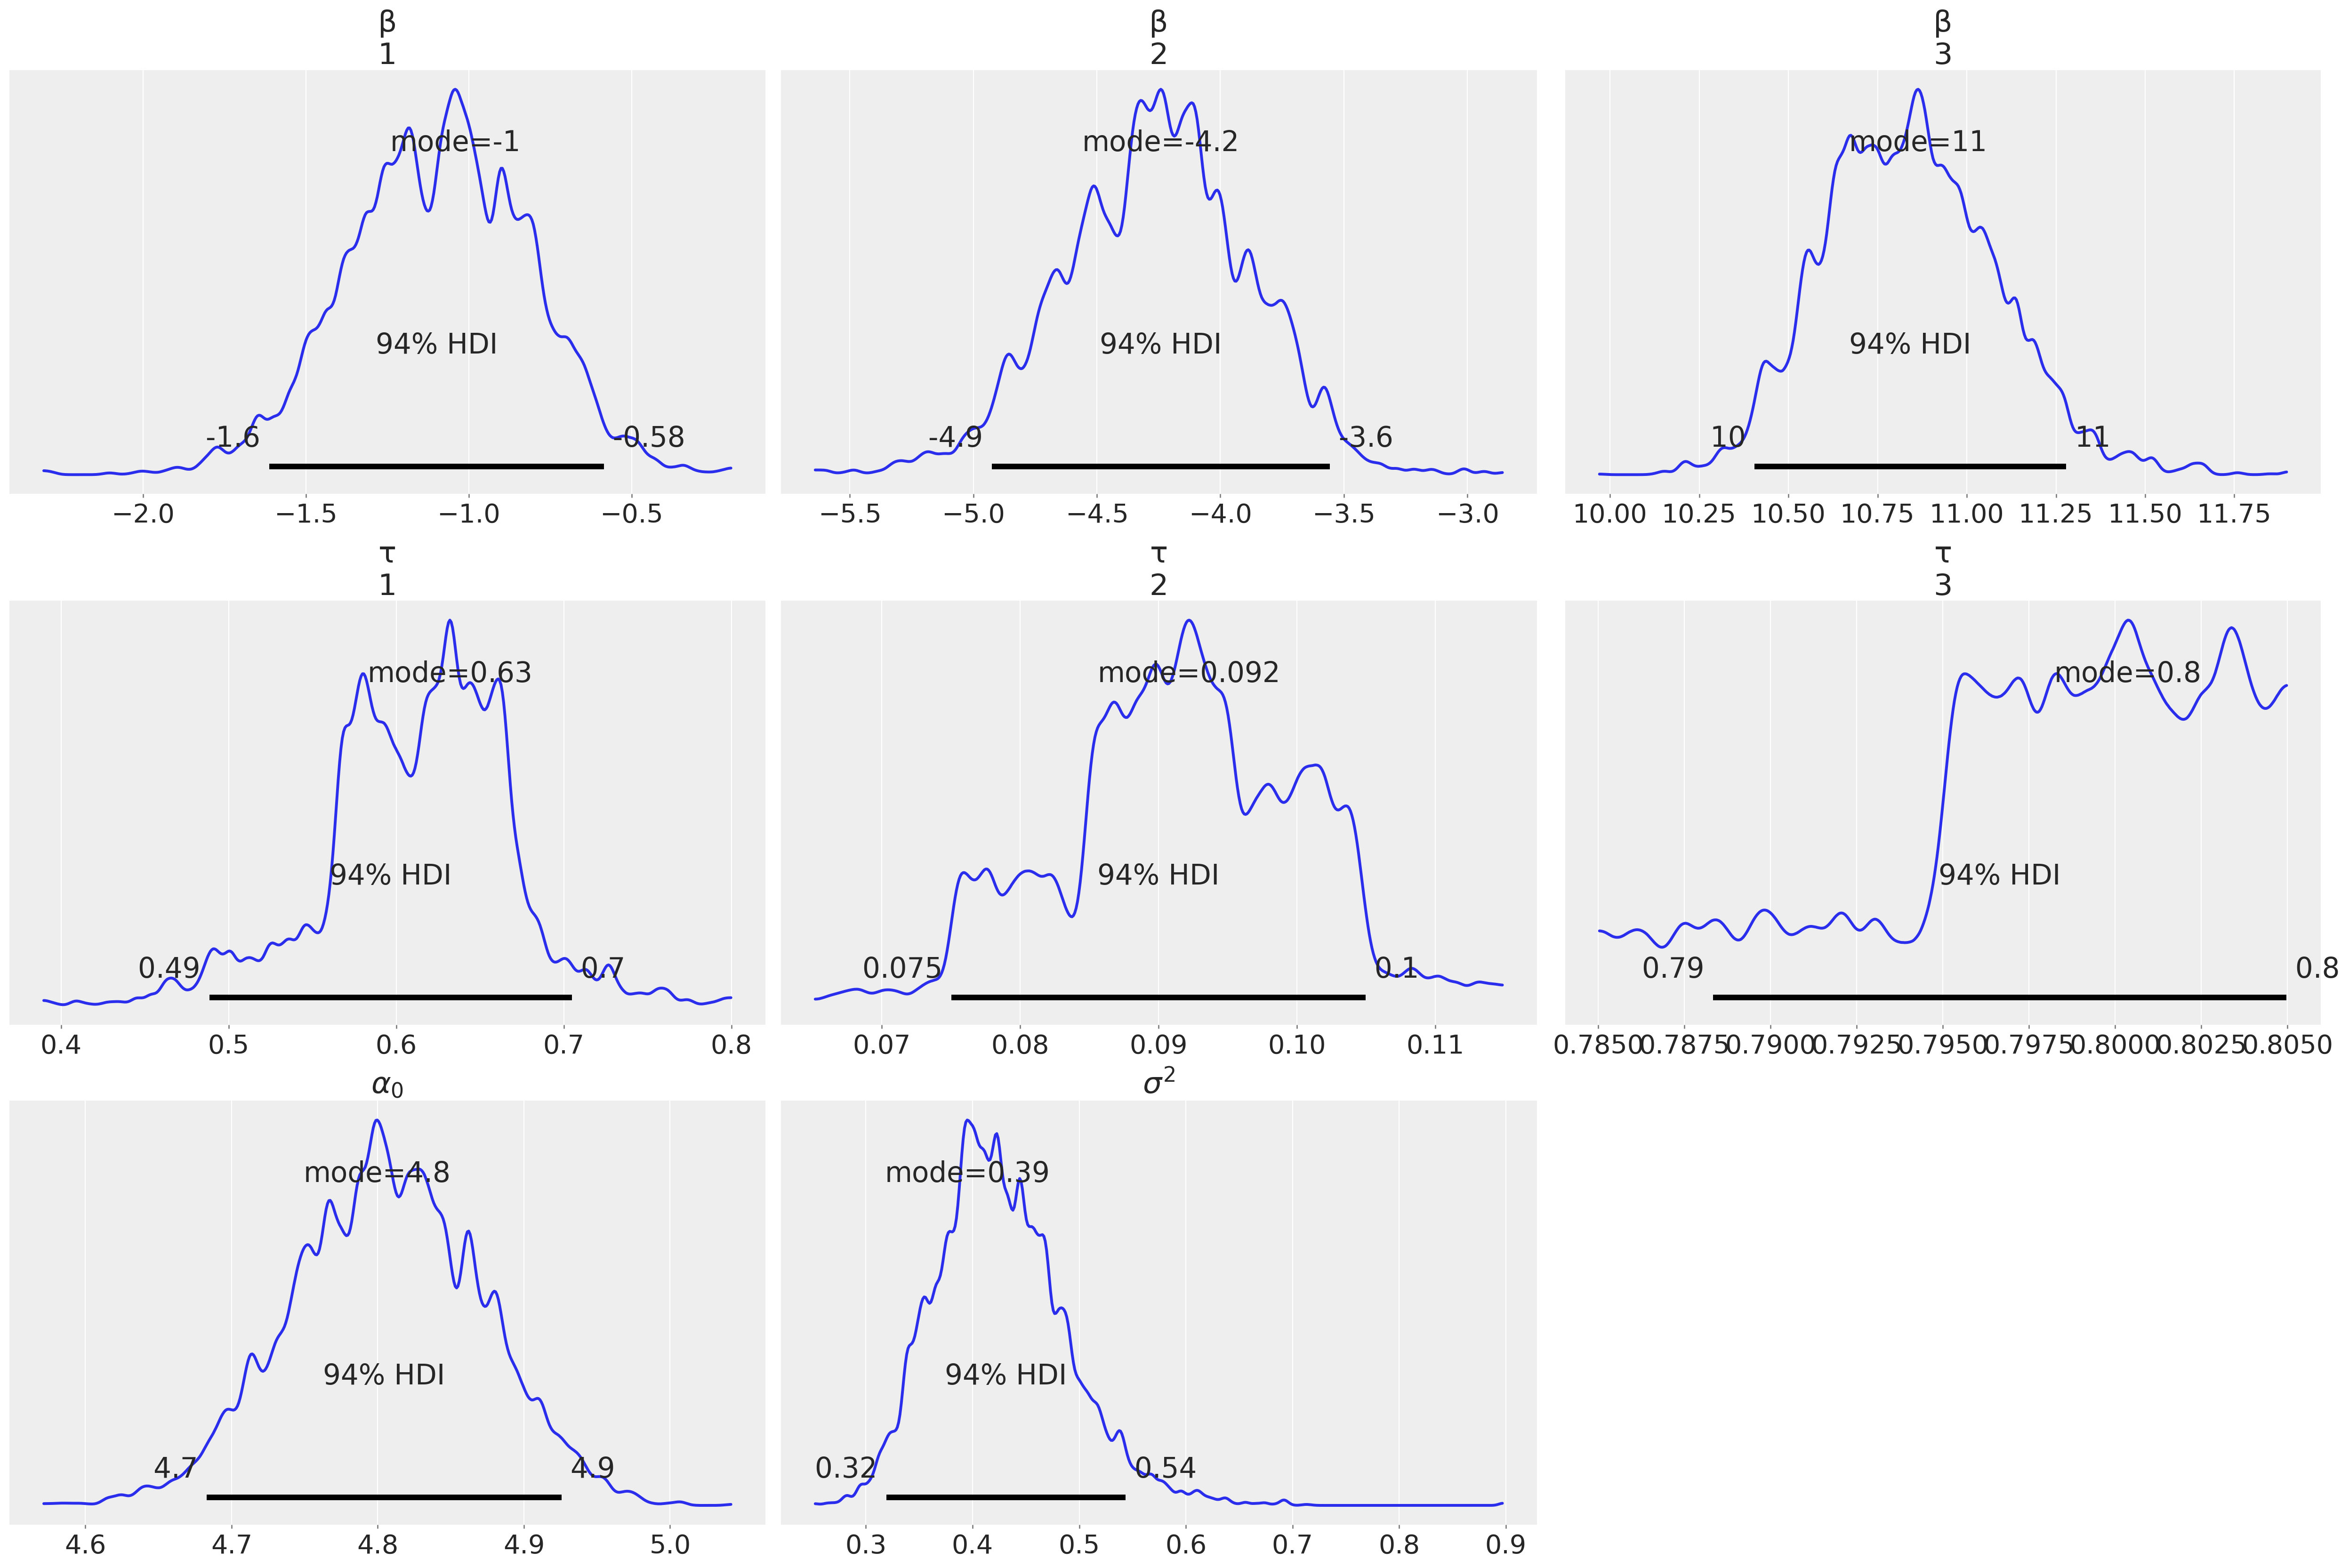

In [29]:
# -- Marginal posterior plot

plot_utils.plot_posterior(
    idata_pymc,
    theta_space,
    gridsize=(NROWS(theta_space.n_dim), NCOLS),
    textsize=20,
)

print("Marginal posterior distributions:")

In [ ]:
# -- Forest plot

plot_utils.plot_forest(
    idata_pymc, 
    theta_space, 
    textsize=10, 
    var_names=[theta_names[theta_space.beta_idx_grouped], 
               theta_names[theta_space.tau_idx_grouped]]
)

print("Forest plot of 94% HDI for β and τ:")

In [89]:
# -- Generate and plot posterior predictive checks from X

pp = bayesian_model.generate_pp(
    idata_pymc, X, theta_space,
    rng=rng, kind='linear', verbose=True)
utils.pp_to_idata([pp], idata_pymc, ['y_star'], merge=True)

# Plot posterior predictive checks
plot_utils.plot_checks_linear(idata_pymc, test=False)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = bayesian_model.bpv(pp, Y, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

NameError: name 'idata_pymc' is not defined

Combined autocorrelation times:


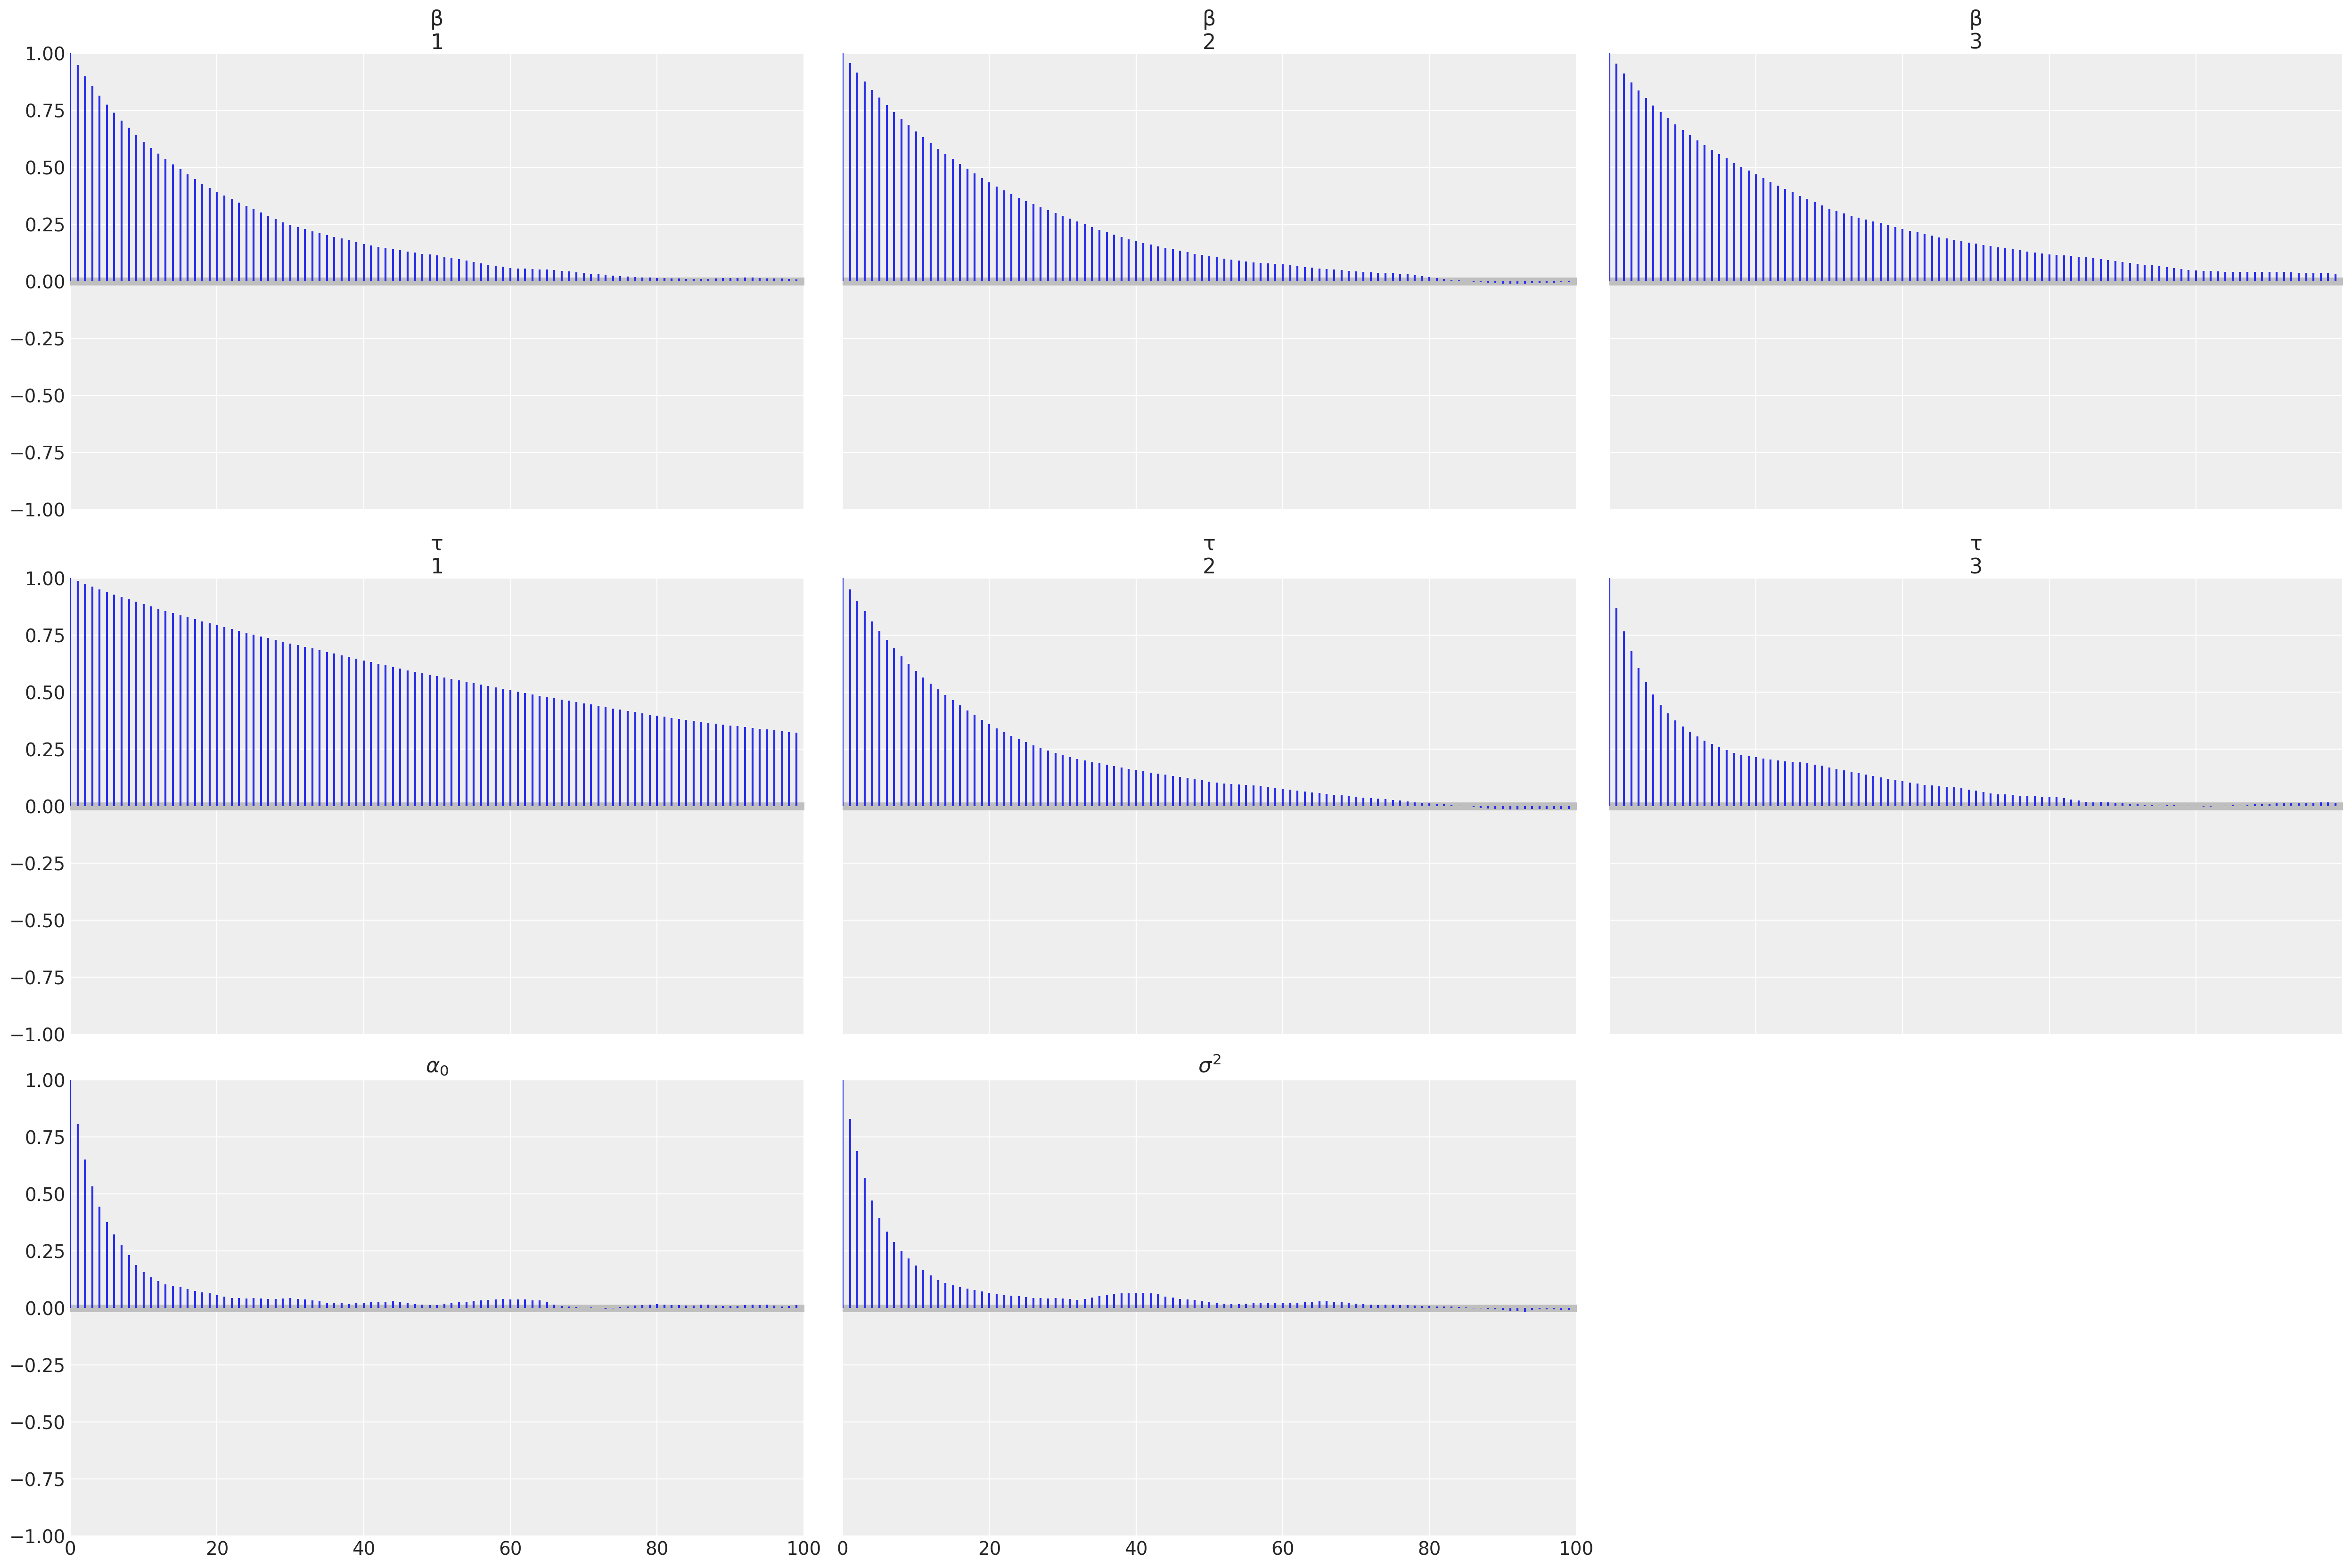

In [31]:
# -- Autocorrelation

plot_utils.plot_autocorr(
    idata_pymc,
    theta_space,
    gridsize=(NROWS(theta_space.n_dim), NCOLS)
)

print("Combined autocorrelation times:")

Graphical model:


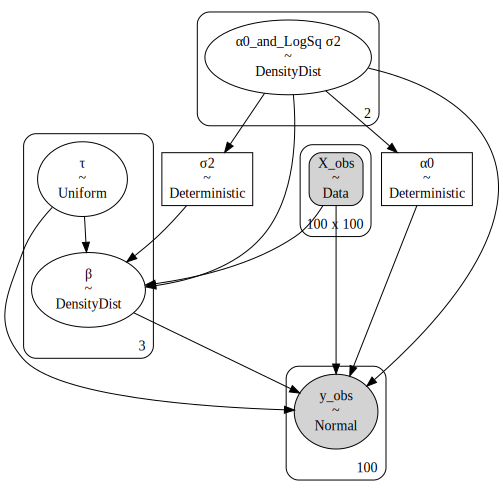

In [32]:
# -- Graphical model

print("Graphical model:")
reg_pymc.to_graphviz()

### Out-of-sample predictions

First we take a look at the distribution of predictions on a previously unseen dataset.

In [90]:
# -- Generate and plot posterior predictive checks from X_test

pp_test = bayesian_model.generate_pp(
    idata_pymc, X_test, theta_space,
    rng=rng, kind='linear', verbose=True)
idata_pp_test = utils.pp_to_idata(
    [pp_test], idata_pymc, ['y_star'], y_obs=Y_test)

# Plot posterior predictive checks
plot_utils.plot_checks_linear(idata_pp_test, test=True)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = bayesian_model.bpv(pp_test, Y_test, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

NameError: name 'idata_pymc' is not defined

Next we look at the MSE when using several point-estimates for the parameters, as well as the mean of the posterior samples.

In [98]:
# -- Compute metrics using several point estimates

# Posterior mean estimate
Y_pred_pp = pp_test[:, ::thin_pp, :].mean(axis=(0, 1))
df_metrics_pymc = utils.linear_regression_metrics(
    Y_test,
    Y_pred_pp,
    reg_pymc.n_components("posterior_mean"),
    "pymc_posterior_mean"
)

# Point estimates
for pe in reg_pymc.default_point_estimates:
    Y_pred_pe = reg_pymc.predict(X_test, strategy=pe)
    df_metrics_pymc = utils.linear_regression_metrics(
        Y_test,
        Y_pred_pe,
        reg_pymc.n_components(pe),
        "pymc_" + pe,
        df=df_metrics_pymc,
    )

df_metrics_pymc.style.hide(axis="index")

NameError: name 'reg_pymc' is not defined

In [35]:
# -- Test variable selection procedure

df_metrics_pymc_var_sel = None

for pe in reg_pymc.default_point_estimates:
    X_red = reg_pymc.transform(X, pe=pe)
    X_test_red = reg_pymc.transform(X_test, pe=pe)

    df_metrics_pymc_var_sel = utils.multiple_linear_regression_cv(
        X_red,
        Y,
        X_test_red,
        Y_test,
        folds,
        n_jobs=N_CORES,
        prefix="pymc",
        pe=pe,
        df=df_metrics_pymc_var_sel,
        random_state=SEED,
    )

df_metrics_pymc_var_sel.style.hide(axis="index")

### Save & Load

In [42]:
# -- Save

_ = idata_pymc.to_netcdf("pymc-linear.nc")

In [43]:
# -- Load

idata_pymc = az.from_netcdf("pymc-linear.nc")

## Notebook metadata

In [36]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Jun 03 2022

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 7.30.1

arviz     : 0.12.1
skfda     : 0.0
numpy     : 1.22.1
pandas    : 1.4.2
emcee     : 3.1.2
autopep8  : 1.6.0
pymc3     : 3.11.5
json      : 2.0.9
matplotlib: 3.5.2
sys       : 3.9.13 (main, May 19 2022, 08:22:48) 
[GCC 12.1.0]

Watermark: 2.2.0

